# UHS3 AA V1-3 STRUCTURE Plots with 1000g

**Author:** Jesse Marks

**GitHub Issue**: [#117](https://github.com/RTIInternational/bioinformatics/issues/117) 


Creating STRUCTURE plots for UHS3 

## Data Description
These data were retrieved from AWS S3 at `s3://rti-midas-data/studies/hiv/observed/final/`

##  STRUCTURE Analysis—Detecting ancestral outliears 
[STRUCTURE](https://web.stanford.edu/group/pritchardlab/structure.html) is a software tool that can be used to identify admixed individuals, among other uses. By comparing the study subjects with reference panel populations such as HapMap or 1000 Genomes, we can estimate the composition of an individual's ancestry to determine any discrepancies between self-reporting and genetic information. For this study data, we will be comparing the individuals to 3 different superpopulations from the 1000 Genomes Phase 3 reference panel

* AFR (African)
* EAS (East Asian)
* EUR (European)

**SNP subset selection**
For computational efficiency 10,000 SNPs are randomly chosen from the intersection of SNPs in the study data with the 3 1000 Genomes superpopulations of interest. As of 10/09/2017 the binary filesets per chromosome in PLINK format for 1000G Phase 3 can be found in 
`/shared/data/ref_panels/1000G/2013.05/plink`. According to the [1000 Genomes paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4750478/).

**NOTE:** The location `/shared/data/ref_panels/1000G/2014.10/1000GP_Phase3` also contatins 1000G phase 3 data derived from the May 2013 release. The difference is that it was downloaded from the [IMPUTE2 website](https://mathgen.stats.ox.ac.uk/impute/1000GP_Phase3.html) and reformatted to be directly compatible with IMPUTE2.

### EA

In [ ]:
ancestry=ea
study=uhs3
version="V1-3"
baseD=/shared/jmarks/heroin/$study/$ancestry/$version
mkdir -p $baseD/structure

## download data to $baseD ##
aws s3 cp s3://rti-midas-data/studies/hiv/observed/final/$study.$ancestry.$version.bed $baseD/
aws s3 cp s3://rti-midas-data/studies/hiv/observed/final/$study.$ancestry.$version.bim $baseD/
aws s3 cp s3://rti-midas-data/studies/hiv/observed/final/$study.$ancestry.$version.fam $baseD/

In [ ]:
# The following python script should be placed in ~/bin

### python ###
import sys
################################################################################

def main():
    infile = sys.argv[1]
    if sys.argv[2] == "keep_snps":
        keep_snps(infile)
    elif sys.argv[2] == "retain_rs":
        retain_rs(infile)


def keep_snps(infile):
    """
    Returns a list of SNPs to keep. In particular, those SNPs
    which have rsIDs.
    """
    outfile = "snps.to.keep"
    with open(infile) as inF, open(outfile, "w") as outF:
        line = inF.readline()
        while line:
            sl = line.split()
            idcol = sl[1]
            if idcol[:2] == "rs":
                outF.write(idcol + "\n")

            line = inF.readline()
keep_snps(infile)

def retain_rs(infile):
    """
    prints lines that have rsIDs. It expects the IDs to be
    in impute2 format---rsID:position:A1:A2
    This only keeps the rsID portion
    """

    outfile = infile[0:-3] + "rsid.bim"
    with open(infile) as inF, open(outfile, "w") as outF:
        line = inF.readline()
        while line:
            sl = line.split()
            idcol = sl[1]
            if idcol[:2] == "rs":
                idcol = idcol.split(":")
                sl[1] = idcol[0]
                newline = "\t".join(sl)
                outF.write(newline + "\n")

            line = inF.readline()

retain_rs(infile)

################################################################################
if __name__ == "__main__":
    main()

In [ ]:
## convert impute2 format to just rsID
################################################################################
python ~/bin/rsid.py $baseD/$study.$ancestry.$version.bim keep_snps

## create new PLINK file set
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --bfile $baseD/$study.$ancestry.$version\
    --extract $baseD/snps.to.keep \
    --make-bed \
    --out $baseD/$study.$ancestry.rs.only
    
    
python ~/bin/rsid.py $baseD/$study.$ancestry.rs.only.bim retain_rs
    
## create new PLINK file set
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --bed $baseD/$study.$ancestry.rs.only.bed \
    --bim $baseD/$study.$ancestry.rs.only.rsid.bim \
    --fam $baseD/$study.$ancestry.rs.only.fam \
    --make-bed \
    --out $baseD/$study.$ancestry.rsid

## Get lists of non-A/T and non-C/G SNPs ##
perl -lane 'if (($F[4] eq "A" && $F[5] ne "T") || ($F[4] eq "T" && $F[5] ne "A") || ($F[4] eq "C" && $F[5] ne "G") || ($F[4] eq "G" && $F[5] ne "C")) { print $F[1]; }' \
    $baseD/$study.$ancestry.rs.only.rsid.bim | \
sort -u | \
grep "rs" \
> $baseD/structure/${study}_no_at_cg_snps.txt

#
wc -l $baseD/structure/${study}_no_at_cg_snps.txt
"""
1561093 /shared/jmarks/heroin/uhs3/aa/V1-3/structure/uhs3_no_at_cg_snps.txt
"""


# Get list of variants from 1000G
mkdir $baseD/structure/1000g_data
#/shared/bioinformatics/software/scripts/qsub_job.sh \
#    --job_name merge_1000g_snps \
#    --script_prefix $baseD/structure/1000g_data/merge_1000g_snps \
#    --mem 3 \
#    --priority 0 \
#    --program "cut -f2,2 /shared/data/ref_panels/1000G/2013.05/plink/ALL.chr{1..22}.bim | \
#        grep \"rs\" | \
#        sort -u > $baseD/structure/1000g_data/1000g_phase3_snps.txt"
ln -s ~/bin/1000g_phase3_snps.txt $baseD/structure/1000g_data/

# This should always be 79,873,045
#wc -l $baseD/structure/1000g_data/1000g_phase3_snps.txt
#"""
#79873045 structure/1000g_data/1000g_phase3_snps.txt
#"""

# Get SNP overlap between study data and 1000G
comm -12 $baseD/structure/${study}_no_at_cg_snps.txt $baseD/structure/1000g_data/1000g_phase3_snps.txt >\
    $baseD/structure/${study}_1000g_shared_snps.txt

wc -l $baseD/structure/${study}_1000g_shared_snps.txt 
"""
1491965 /shared/jmarks/heroin/uhs3/aa/V1-3/structure/uhs3_1000g_shared_snps.txt
"""

# Select 10,000 random SNPs from study and 1000G overlap
perl -ne 'print rand()."\t".$_' $baseD/structure/${study}_1000g_shared_snps.txt | \
    sort -k1,1 | \
    head -10000 | \
    cut -f2,2 \
    > $baseD/structure/10k_snp_random_sample.txt

### Extract SNP subset PLINK binary filesets for Study data

In [ ]:
## Create ped and map files for study genotype data for SNP subset ##
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --bed $baseD/$study.$ancestry.rs.only.bed \
    --bim $baseD/$study.$ancestry.rs.only.rsid.bim \
    --fam $baseD/$study.$ancestry.rs.only.fam \
    --extract $baseD/structure/10k_snp_random_sample.txt \
    --snps-only just-acgt \
    --recode \
    --out $baseD/structure/${study}_10k_snp_random_sample

### Extract SNP subset PLINK binary filesets for 1000G data

The 05/2013 release of the 1000 Genomes data have been previously processed and converted to PLINK binary fileset format, but the files include all the 1000G individuals. We are interested in only four superpopulations, so we create filesets specifically for each of these groups. It was brought to my attention that 1000G Phase 3 rsIDs may be duplicated across chromosomes potentially causing chromosome merging issues. For that reason, it is typically recommended to process the chromosomes separately initially, then combine post SNP subsetting. Subject IDs with superpopulation classifications are available at:

`/shared/data/ref_panels/1000G/igsr_samples.tsv`

In [ ]:
## 1000G Ancestry specific directories ##
for pop in {AFR,EAS,EUR}; do
    mkdir $baseD/structure/1000g_data/${pop}
done

# Get subject IDs by ancestry
awk 'BEGIN { FS="\t"; OFS="\t" } { if($7=="African"){print $1,$1} }' /shared/data/ref_panels/1000G/2013.05/igsr_samples.tsv \
    > $baseD/structure/1000g_data/AFR/AFR_subject_ids.txt
awk 'BEGIN { FS="\t"; OFS="\t" } { if($7=="East Asian"){print $1,$1} }' /shared/data/ref_panels/1000G/2013.05/igsr_samples.tsv \
    > $baseD/structure/1000g_data/EAS/EAS_subject_ids.txt
awk 'BEGIN { FS="\t"; OFS="\t" } { if($7=="European"){print $1,$1} }' /shared/data/ref_panels/1000G/2013.05/igsr_samples.tsv \
    > $baseD/structure/1000g_data/EUR/EUR_subject_ids.txt

# Make new binary filesets for each 1000G group
# only keeping the data from individuals which are from 1 of the three super populations
for pop in {AFR,EAS,EUR}; do
    for chr in {1..22}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${pop}_${chr}_filter \
            --script_prefix $baseD/structure/1000g_data/${pop}/ancestry_partition_chr${chr} \
            --mem 15.5 \
            --priority 0 \
            --program /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink  \
                --noweb \
                --memory 10000 \
                --bfile /shared/data/ref_panels/1000G/2013.05/plink/ALL.chr${chr} \
                --keep $baseD/structure/1000g_data/${pop}/${pop}_subject_ids.txt \
                --extract $baseD/structure/10k_snp_random_sample.txt \
                --make-bed \
                --out $baseD/structure/1000g_data/${pop}/${pop}_chr${chr}_10k_snp_random_sample
    done
done


# Create merge lists and merge autosomes for each 1000G population
data_dir=$baseD/structure/1000g_data
for pop in {AFR,EAS,EUR}; do
    echo "${data_dir}/${pop}/${pop}_chr1_10k_snp_random_sample" > ${data_dir}/${pop}/${pop}_autosome_merge_list.txt
    for chr in {2..22}; do
        echo "${data_dir}/${pop}/${pop}_chr${chr}_10k_snp_random_sample" \
        >> ${data_dir}/${pop}/${pop}_autosome_merge_list.txt
    done
done

for pop in {AFR,EAS,EUR}; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name ${pop}_merge_plink_filesets \
        --script_prefix $baseD/structure/1000g_data/${pop}/merge_plink_filesets \
        --mem 4 \
        --priority 0 \
        --program /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --memory 4000 \
            --merge-list $baseD/structure/1000g_data/${pop}/${pop}_autosome_merge_list.txt \
            --snps-only just-acgt \
            --make-bed \
            --out $baseD/structure/1000g_data/${pop}/${pop}_all_autosomes_10k_snp_random_sample
done

### Discrepancy assessment between Study and 1000G data
As a quality check that the SNP data subsampled from the Kreek and 1000 Genomes data are the same, I will attempt to merge an arbitrarily selected group from each data set using PLINK. If any errors are found, PLINK will generate an error file. Likely causes of errors would be:

* SNP genomic coordinates not matching
* SNP duplicates found
* SNP strand orientation flipped

If errors are found the two options for moving forward are

1. Re-run the 10,000 SNP subsampling and hope the SNPs chosen do not raise issues
2. Remove the problematic SNPs
Option #2 is the prefered approach and the one I will be taking.

In [ ]:
# Merge Study and EUR genotype files
if [ $ancestry == aa ]; then
    mypop=AFR
    else
    mypop=EUR
fi

# --merge-mode 7 (no merge) Report mismatching nonmissing calls.
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --file $baseD/structure/${study}_10k_snp_random_sample \
    --bmerge $baseD/structure/1000g_data/${mypop}/${mypop}_all_autosomes_10k_snp_random_sample \
    --merge-mode 7 \
    --out $baseD/structure/1000g_${mypop}_${study}_10k_snp_random_sample


    
wc -l $baseD/structure/*missnp
#"2"

### STRUCTURE input file construction
Because our initial merge was unsuccessful, we will proceed by simply removing those two snps.

In [ ]:
## EC2 console ##
any_to_remove="yes"

if [ $any_to_remove == "yes" ]; then
    # Create final ped and map files for Study genotype data for SNP subset
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 3000 \
        --bfile $baseD/$study.$ancestry.rsid \
        --extract $baseD/structure/10k_snp_random_sample.txt \
        --exclude $baseD/structure/*missnp \
        --snps-only just-acgt \
        --recode \
        --out $baseD/structure/${study}_10k_snp_random_sample.final
                     
    for pop in {AFR,EAS,EUR}; do
        /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --memory 1024 \
            --bfile $baseD/structure/1000g_data/${pop}/${pop}_all_autosomes_10k_snp_random_sample \
            --exclude $baseD/structure/*missnp \
            --recode \
            --out $baseD/structure/1000g_data/${pop}_10k_snp_random_sample.final
    done
                                                                       
else
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 3000 \
        --bfile $baseD/$study.$ancestry.rsid \
        --extract $baseD/structure/10k_snp_random_sample.txt \
        --snps-only just-acgt \
        --recode \
        --out $baseD/structure/${study}_10k_snp_random_sample.final
        
# Create ped and map files for each 1000G population
    for pop in {AFR,EAS,EUR}; do
        /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --memory 1024 \
            --bfile $baseD/structure/1000g_data/${pop}/${pop}_all_autosomes_10k_snp_random_sample \
            --recode \
            --out $baseD/structure/1000g_data/${pop}_10k_snp_random_sample.final
    done
fi


# Final check for SNP discrepancies
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --file $baseD/structure/${study}_10k_snp_random_sample.final \
    --merge $baseD/structure/1000g_data/${mypop}_10k_snp_random_sample.final \
    --recode \
    --out $baseD/structure/structure_input_test2


wc -l  $baseD/structure/structure_input_test*.map
#"""
#9998 /shared/jmarks/heroin/uhs3/ea/V1-3/structure/structure_input_test2.map
#"""

No merging issues were identified in the final check, so I will use the script ped2structure.pl to convert the PED file into a STRUCTURE input file format. This script takes two inputs. The first is an integer that serves as an ID to distinguish between a reference panel population or a study data set group. The second input is an integer that is unique to each group/population regardless of whether it's from the study or 1000G data.

The goal of the conversion script is to generate a single STRUCTURE input file containing genotype information for the ~10,000 (post-filtered) subsampled SNPs and the individuals from the study and 1000G data sets. Documentation on the format can be found [here](https://web.stanford.edu/group/pritchardlab/structure_software/release_versions/v2.3.4/structure_doc.pdf). The first three columns contatin the following information respectively

1. Subject identifier
2. Group/population identifier. Distinct for each ancestry group or superpopulation
3. Boolean indicator (1=True, 0=False) specifying reference panel populations. This is used by STRUCTURE to define the ancestry groups

We will be running structure assuming that the study subjects descended from three populations. The traditional approach would be to use AFR, EAS, and EUR. I will run STRUCTURE using these 1000G superpopulations.

Note: for $K$ reference panel populations used for ancestry comparisons, the reference panel populations must be given group IDs between 1 and $K$.

In [ ]:
## EC2 console ##
mkdir $baseD/structure/input_files
function create_input {

    groupID=1 #distinguish between all groups

    # Append 1000G populations to STRUCTURE file
    truncate -s 0 $baseD/structure/input_files/input_afr_eas_eur
    for pop in {AFR,EAS,EUR}; do
        cat $baseD/structure/1000g_data/${pop}_10k_snp_random_sample.final.ped | \
        /shared/bioinformatics/software/perl/file_conversion/ped2structure.pl 1 ${groupID} \
        >> $baseD/structure/input_files/input_afr_eas_eur
        groupID=`echo ${groupID} + 1 | bc`
    done
    
    echo "1000G done, now process study subjects"

    # Append remaining ancestry groups to STRUCTURE file
    cat $baseD/structure/${study}_10k_snp_random_sample.final.ped | \
    /shared/bioinformatics/software/perl/file_conversion/ped2structure.pl 0 ${groupID} \
    >> $baseD/structure/input_files/input_afr_eas_eur
        groupID=`echo ${groupID} + 1 | bc` 
    #done
}

create_input &

In [ ]:
## sandbox ##
groupID=1 #distinguish between all groups
baseD=/shared/jmarks/heroin/uhs2/aa

# Append 1000G populations to STRUCTURE file
truncate -s 0 /structure/input_files/tmp/input_afr_eas_eur
for pop in {AFR,EAS,EUR}; do
    cat $baseD/structure/1000g_data/${pop}_10k_snp_random_sample.final.ped | \
    /shared/bioinformatics/software/perl/file_conversion/ped2structure.pl 1 ${groupID} \
    >> $baseD/structure/input_files/input_afr_eas_eur
    groupID=`echo ${groupID} + 1 | bc`
done

### Run STRUCUTRE
For running STRUCTURE, the following command line parameters are explicitly specified

* m - Main parameter file
* e - Additional parameter file
* i - Input data file
* o - Output file
* L - Number of loci in data file
* N - Number of subjects
* K - Maximum number of populations

The remaining parameters are specified in the mainparams and extraparams files. Any values specified on the command-line override the values in the configuration files. Documentation on the parameter options can be found [here](https://web.stanford.edu/group/pritchardlab/structure_software/release_versions/v2.3.4/structure_doc.pdf).

Because I am using combinations of three from the four 1000G superpopulations, I will run STRUCTURE for each of these combinations.

In [ ]:
## EC2 console ##

mkdir $baseD/structure/output_files

# Run Structure using AFR, EAS, and EUR
# Why add the random number generator flag?
L=$(wc -l $baseD/structure/${study}_10k_snp_random_sample.final.map | perl -lane 'print $F[0];')
N=$(wc -l $baseD/structure/input_files/input_afr_eas_eur | perl -lane 'print $F[0]/2;')
sh /shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name structure_1KG.$study.$ancestry.$version \
    --script_prefix $baseD/structure/output_files/structure_afr_eas_eur \
    --mem 15 \
    --nslots 4 \
    --priority 0 \
    --program /shared/bioinformatics/software/third_party/structure_v2.3.4/console/structure \
         -m /shared/bioinformatics/software/third_party/structure_v2.3.4/console/mainparams \
         -e /shared/bioinformatics/software/third_party/structure_v2.3.4/console/extraparams \
         -i $baseD/structure/input_files/input_afr_eas_eur \
         -o $baseD/structure/output_files/output_afr_eas_eur \
         -L $L \
         -N $N \
         -K 3 \
         -D 1523031945

### Producing triangle plots
[Triangle or ternary plots](https://en.wikipedia.org/wiki/Ternary_plot) provide a means to visualize membership strength. For the purposes of the Kreek data, the triangle plots are used to determine how similar self-reports of individuals from a Kreek ancestry group are to three disparate reference populations. The visualizations allow for the identification of potential outliers that would be removed from downstream processing and analysis.

**Note**: The command line Perl script below assumes a specific order of the STRUCTURE output data in regards to the group IDs. Modifications should be made as necessary to ensure that the labels match with the ID. Additionally, `triangle_plot.R` does not check that the cluster specifications match the given 1000G superpopulation labels. Be sure to assign the right label to the right group ID from previous processing steps.

In [ ]:
## EC2 console ##
mkdir $baseD/structure/triangle_plots
myvar=${study^^}.$version

#### AFR, EAS, and EUR (order matters)####

# Prepare results for triangle plot
# note to change @datasets to reflect current study
perl -sne 'if (/%Miss/) {
              $in=1;
              print "num\tID\tpop\tcluster1\tcluster2\tcluster3\n";
          }
          if ($in==1 && !/Label/ && !/^\s+$/) {
              @datasets=("AFR","EAS","EUR", "$study");
              s/^\s+//g;
              @F=split /\s+/;
              # Grab only study groups by ID
              if ($F[3] > 3) {
                  print $F[0]."\t".$F[1]."\t".$datasets[$F[3]-1]."\t".$F[5]."\t".$F[6]."\t".$F[7]."\n";
              }
          } 
          s/\s+//g;
          if ($_ eq "") { $in=0; }' -- -study=$myvar $baseD/structure/output_files/output_afr_eas_eur_f > \
    $baseD/structure/triangle_plots/afr_eas_eur.triangle_input

# Prepare id xref file
perl -ne 'if ($count==0) { print "num\tID\n"; }
          if (!defined $even) { print STDERR "LALALA\n";} 
          if ($even==0) {/^(\S+)/; print $count+1; print "\t".$1."\n"; $count++; $even=1}
          else {$even=0}' $baseD/structure/input_files/input_afr_eas_eur > \
    $baseD/structure/triangle_plots/afr_eas_eur_id_xref

# Generate triangle plot
Rscript /shared/bioinformatics/software/R/triangle_plot.R \
    --data $baseD/structure/triangle_plots/afr_eas_eur.triangle_input \
    --prefix $baseD/structure/triangle_plots/afr_eas_eur \
    --cluster1 African \
    --cluster2 Asian \
    --cluster3 European \
    --xref $baseD/structure/triangle_plots/afr_eas_eur_id_xref

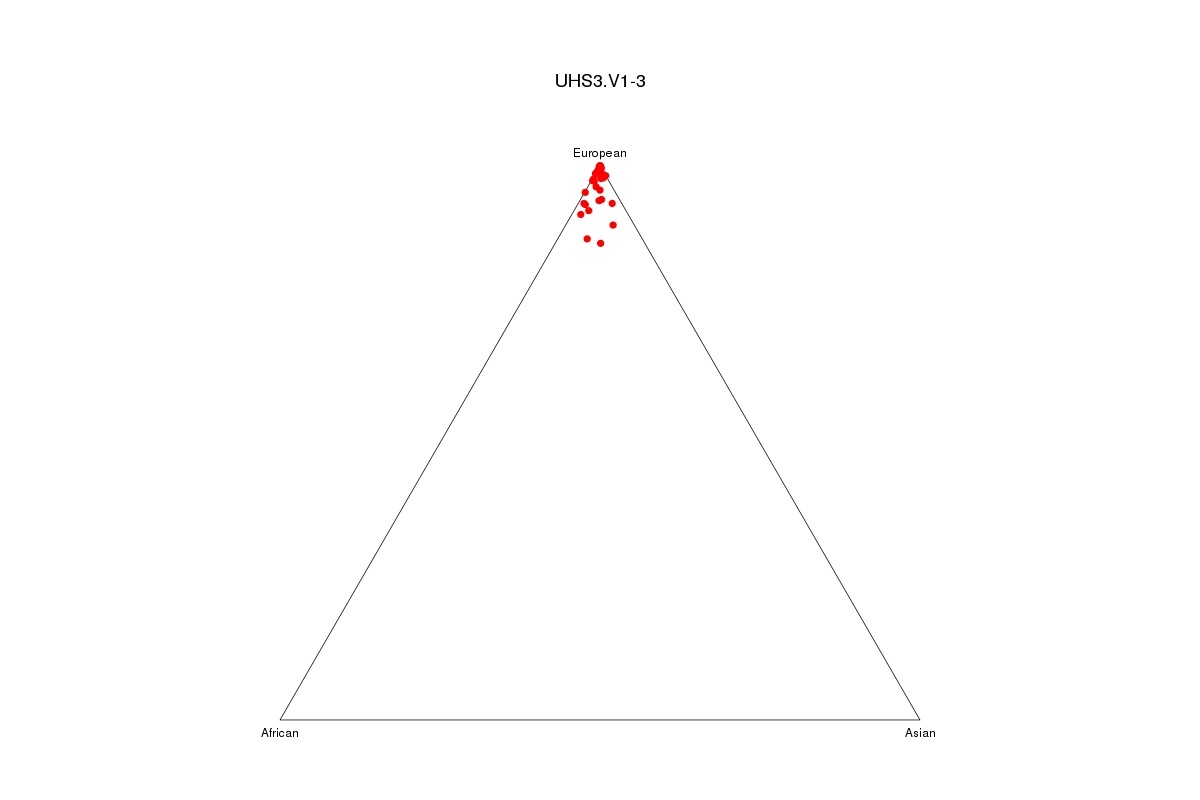

In [1]:
## R console ##
library("IRdisplay")
display_png(file="C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/heroin/ngc/uhs3/V1-3/ea/afr_eas_eur_UHS3.V1-3.jpg", width=800, height=800)

#### Reassigning and removing outliers
The following retainment thresholds should be implemented:


| Action Description | Thresholding Criteria      |
|--------------------|----------------------------|
| For EA retainment | (AFR < 25%)$ \wedge $(EAS < 25%) |
| For AA retainment | (AFR > 25%)$ \wedge $(EAS < 25%) |
| For HA retainment | (AFR < 25%)$ \wedge $(EAS > 25%) |

Subject counts after applying the filters above.
```
wc -l *filtered
  603 aa_filtered
  896 ea_filtered
  430 ha_filtered
 1929 total
```

In [ ]:
## EC2 command line
### get details on which subjects are reassigned ###

plots=$baseD/structure/triangle_plots/no_self
mkdir $plots

cp $baseD/structure/triangle_plots/afr_eas_eur.triangle_input $plots/

# AA retained
#--------------------------------------------------------------------------------
# Create triangle plot input with potential outliers filtered
eth=AA

head -1 $baseD/structure/triangle_plots/afr_eas_eur.triangle_input > \
    $plots/afr_eas_eur_filtered.triangle_input

tail -n +2 $plots/afr_eas_eur.triangle_input | \
    perl -lane 'if (($F[3] > 0.25 && $F[4] < 0.25)) { print $_ }' \
    > $plots/aa_filtered

# study=uhs4, for example
awk -v study="$study" -v eth="$eth" 'BEGIN{OFS="\t"} {$3=study "_" eth;print $0}'  \
    $plots/aa_filtered >> $plots/afr_eas_eur_filtered.triangle_input


# EA retained
#--------------------------------------------------------------------------------
# Create triangle plot input with potential outliers filtered
eth=EA

tail -n +2 $plots/afr_eas_eur.triangle_input |\
    perl -lane 'if (($F[3] < 0.25 && $F[4] < 0.25)) { print $_; }' \
    > $plots/ea_filtered
awk -v study="$study" -v eth="$eth" 'BEGIN{OFS="\t"} {$3=study "_" eth;print $0}' \
    $plots/ea_filtered >> $plots/afr_eas_eur_filtered.triangle_input
#--------------------------------------------------------------------------------

# HA retained
#--------------------------------------------------------------------------------
# Create triangle plot input with potential outliers filtered
eth=HA

tail -n +2 $plots/afr_eas_eur.triangle_input |\
    perl -lane 'if (($F[3] < 0.25 && $F[4] > 0.25)) { print $_; }' \
    > $plots/ha_filtered
awk -v study="$study" -v eth="$eth" 'BEGIN{OFS="\t"} {$3=study "_" eth;print $0}' \
    $plots/ha_filtered >> $plots/afr_eas_eur_filtered.triangle_input
--------------------------------------------------------------------------------

# subjects not assigned to any ancestry group
cat $plots/*filtered | sort > $plots/all.assigned
comm -13 $plots/all.assigned <(tail -n +2 $plots/../afr_eas_eur.triangle_input)  >\
    $plots/not.assigned
head -1 $plots/afr_eas_eur_filtered.triangle_input > $plotst/not.assigned.triangle_input 
cat $plots/not.assigned >> $plots/not.assigned.triangle_input

_______________________________________________________________________________________________________________________________________________________
# Generate triangle plot
Rscript /shared/bioinformatics/software/R/triangle_plot.R \
    --data $plots/afr_eas_eur_filtered.triangle_input \
    --prefix $plots/afr_eas_eur_filtered \
    --cluster1 African \
    --cluster2 Asian \
    --cluster3 European \
    --xref $baseD/structure/triangle_plots/afr_eas_eur_id_xref


# Generate triangle plot for not assigned subjects
Rscript /shared/bioinformatics/software/R/triangle_plot.R \
    --data $plots/not.assigned.triangle_input \
    --prefix $plots/not.assigned.afr_eas_eur \
    --cluster1 African \
    --cluster2 Asian \
    --cluster3 European \
    --xref $baseD/structure/triangle_plots/afr_eas_eur_id_xref

#### Filtered results

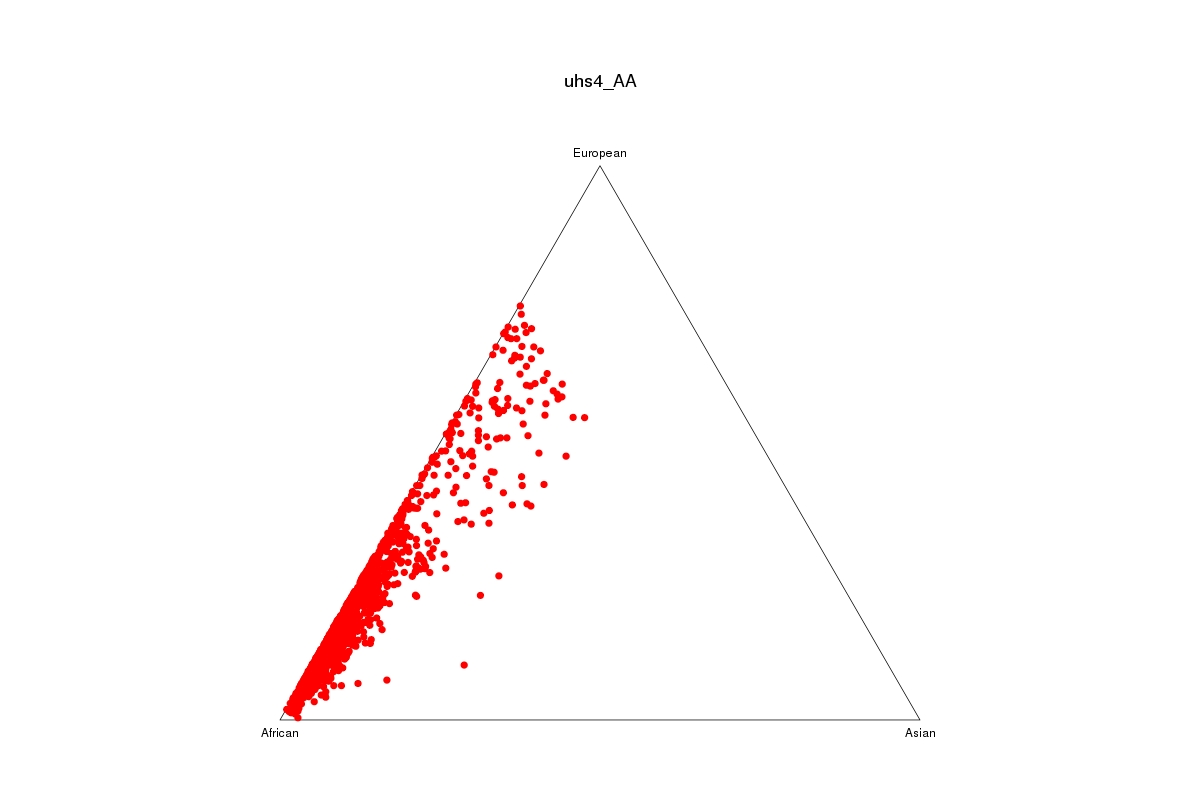

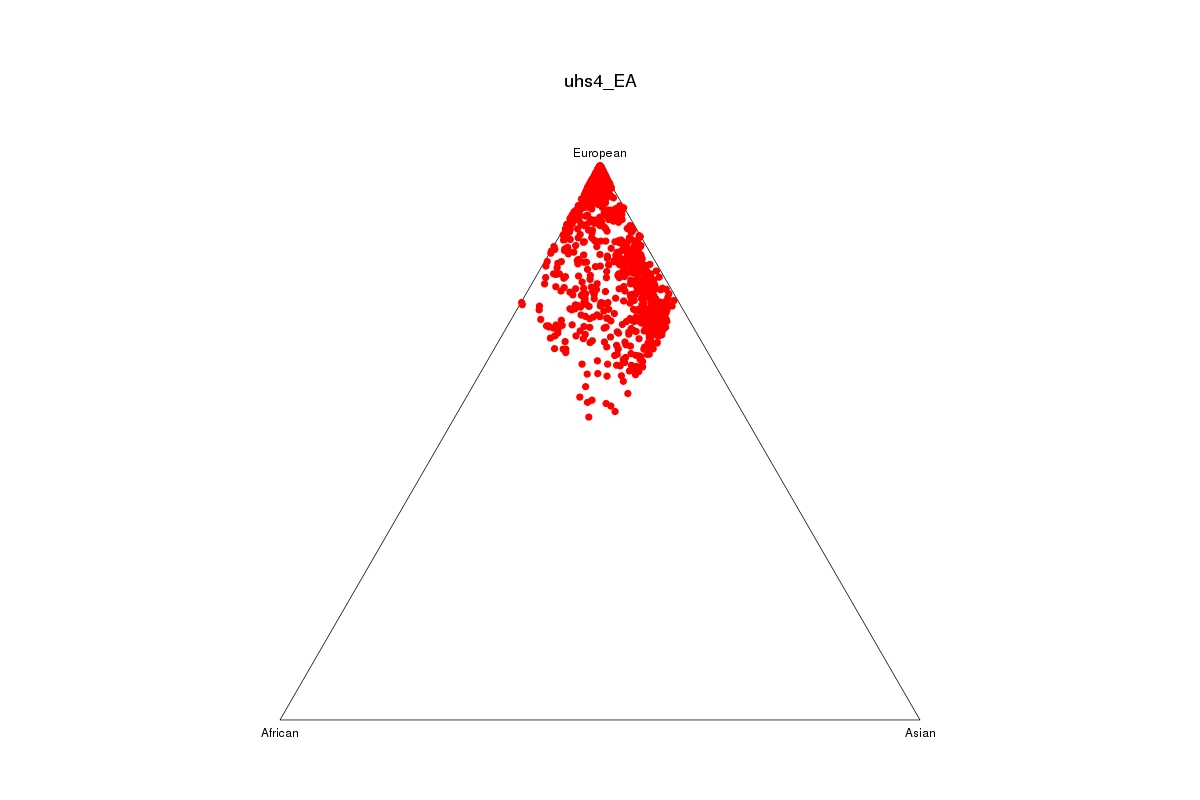

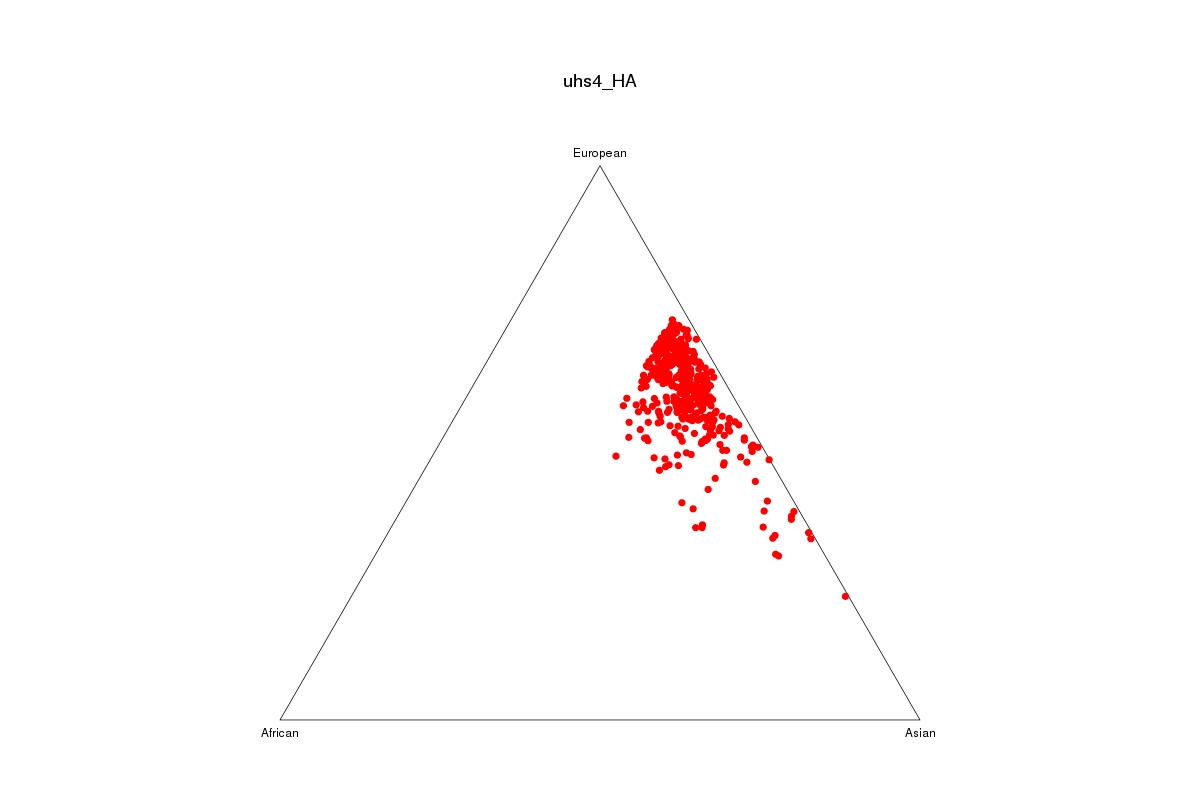

In [5]:
## R console ##
library("IRdisplay")
display_png(file="C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/heroin/ngc/uhs4/qc/filtered/afr_eas_eur_filtered_uhs4_AA.jpg", width=800, height=800)
display_png(file="C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/heroin/ngc/uhs4/qc/filtered/afr_eas_eur_filtered_uhs4_EA.jpg", width=800, height=800)
display_png(file="C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/heroin/ngc/uhs4/qc/filtered/afr_eas_eur_filtered_uhs4_HA.jpg", width=800, height=800)

## Post-Structure
### Create updated PLINK filesets

In [ ]:
#plots=$baseD/structure/triangle_plots/no_self

anlist="ea aa ha"


# get ancestry counts after filtering + create a keepIDs list
for an in $anlist;do
    mkdir -p $baseD/$an/{autosomes,chrX}
    awk -v an="${an^^}" -v study="$study" '$3==study"_"an {print $2}' \
        $plots/afr_eas_eur_filtered_for_filtering.txt > $baseD/$an/subject_ids.keep
    wc -l $baseD/$an/subject_ids.keep
done
"""
896 /shared/jmarks/heroin/uhs4/genotype/observed/processing/001/ea/subject_ids.keep
603 /shared/jmarks/heroin/uhs4/genotype/observed/processing/001/aa/subject_ids.keep
430 /shared/jmarks/heroin/uhs4/genotype/observed/processing/001/ha/subject_ids.keep"""

# split famID_IID up by tab --> famID"\t"IID
for an in $anlist;do
    while read line;do
        half=$(expr ${#line} / 2)
        echo ${line:0:$half} ${line:0:$half}
    done < $baseD/$an/subject_ids.keep > $baseD/$an/subject_ids.keep.txt
done
            
## subjects that were excluded
# create an informative file about subjects that were not
# included in any of the ancestry groups            
clus1=AFR
clus2=EAS
clus3=EUR
awk -v p1=$clus1 -v p2=$clus2 -v p3=$clus3 'NR==1 {
    $4=$4"("p1")";
    $5=$5"("p2 ")" ;
    $6=$6"("p3 ")"} 
    NR>=2 {
    $2=substr($2,1, length($2) - (0.5 * length($2)) )}
{print $0}' \
            $plots/not.assigned.afr_eas_eur_for_filtering.txt >\
            $plots/not.assigned.afr_eas_eur_for_filtering.cleaned.txt   

            
for ancestry in $anlist; do
    echo -e "\n\n======== ${ancestry} ========\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 5000 \
        --bfile $baseD/genotypes_b37_dbsnp138 \
        --keep $baseD/${ancestry}/subject_ids.keep.txt \
        --make-bed \
        --out $baseD/${ancestry}/genotypes_b37_dbsnp138
done

wc -l $baseD/{aa,ea}/*{bim,fam}
"""
  2130946 /shared/data/studies/heroin/uhs4/genotype/observed/processing/002/aa/genotypes_b37_dbsnp138.bim
      793 /shared/data/studies/heroin/uhs4/genotype/observed/processing/002/aa/genotypes_b37_dbsnp138.fam
  2130946 /shared/data/studies/heroin/uhs4/genotype/observed/processing/002/ea/genotypes_b37_dbsnp138.bim
      715 /shared/data/studies/heroin/uhs4/genotype/observed/processing/002/ea/genotypes_b37_dbsnp138.fam
"""

In [ ]:
## EC2 command line

# Create autosome and chrX file sets
for ancestry in $anlist; do
    echo -e "\n\n======== ${ancestry} ========\n\n"
    mkdir $procD/${ancestry}/{chrX,autosomes}

    # Autosomes
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 5000 \
        --bfile $procD/${ancestry}/genotypes_b37_dbsnp138 \
        --autosome \
        --make-bed \
        --out $procD/${ancestry}/autosomes/genotypes_b37_dbsnp138

    # ChrX (include split PARs)
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 5000 \
        --bfile $procD/${ancestry}/genotypes_b37_dbsnp138 \
        --chr 23,25 \
        --make-bed \
        --out $procD/${ancestry}/chrX/genotypes_b37_dbsnp138_unmerged

    # Combine split chrX and PARs
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 5000 \
        --bfile $procD/${ancestry}/chrX/genotypes_b37_dbsnp138_unmerged \
        --merge-x \
        --make-bed \
        --out $procD/${ancestry}/chrX/genotypes_b37_dbsnp138
done

## get counts
 wc -l {ea,aa}/{chrX,autosomes}/*38.bim
"""
    45301 ea/chrX/genotypes_b37_dbsnp138.bim
  2084057 ea/autosomes/genotypes_b37_dbsnp138.bim
    45301 aa/chrX/genotypes_b37_dbsnp138.bim
  2084057 aa/autosomes/genotypes_b37_dbsnp138.bim
"""

In [ ]:
# EC2 command line

# Get flip lists

# Extract unflipped variants
for ancestry in $anlist; do
    for chr in {1..22}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${ancestry}_${chr} \
            --script_prefix $procD/${ancestry}/autosomes/chr${chr}_flip_tests \
            --mem 6 \
            --priority 0 \
            --program  /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
                --noweb \
                --memory 6000 \
                --bfile $procD/${ancestry}/autosomes/genotypes_b37_dbsnp138 \
                --chr ${chr} \
                --make-bed \
                --out $procD/${ancestry}/chr${chr}_unflipped
    done
done


# Attempt merge with 1000G data
for ancestry in $anlist; do
    for chr in {1..22}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${ancestry}_${chr} \
            --script_prefix $procD/${ancestry}/autosomes/chr${chr}_flip_tests \
            --mem 6 \
            --priority 0 \
            --program  /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
                --noweb \
                --memory 6000 \
                --bfile $procD/${ancestry}/chr${chr}_unflipped \
                --bmerge /shared/data/ref_panels/1000G/2013.05/plink/ALL.chr${chr} \
                --merge-mode 7 \
                --out $procD/${ancestry}/chr${chr}_unflipped_test
    done
done

# Flip problematic variants
for ancestry in $anlist; do
    for chr in {1..22}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${ancestry}_${chr} \
            --script_prefix $procD/${ancestry}/autosomes/chr${chr}_flip_tests \
            --mem 6 \
            --priority 0 \
            --program  /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
                --noweb \
                --memory 6000 \
                --bfile $procD/${ancestry}/autosomes/genotypes_b37_dbsnp138 \
                --chr ${chr} \
                --flip $procD/${ancestry}/chr${chr}_unflipped_test.missnp \
                --make-bed \
                --out $procD/${ancestry}/chr${chr}_flipped
    done
done

# Attempt merge with 1000G data
for ancestry in $anlist; do
    for chr in {1..22}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${ancestry}_${chr} \
            --script_prefix $procD/${ancestry}/autosomes/chr${chr}_flip_tests \
            --mem 6 \
            --priority 0 \
            --program  /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
                --noweb \
                --memory 6000 \
                --bfile $procD/${ancestry}/chr${chr}_flipped \
                --bmerge /shared/data/ref_panels/1000G/2013.05/plink/ALL.chr${chr} \
                --merge-mode 7 \
                --out $procD/${ancestry}/chr${chr}_flipped_test
    done
done

# Combine flip lists
for ancestry in $anlist; do
    echo -e "\n\n======== ${ancestry} ========\n\n"
    cat $procD/${ancestry}/chr*_unflipped_test.missnp | sort -u > $procD/${ancestry}/chr_all_unflipped_test.missnp
    cat $procD/${ancestry}/chr*_flipped_test.missnp | sort -u > $procD/${ancestry}/chr_all_flipped_test.missnp
    comm -23 $procD/${ancestry}/chr_all_unflipped_test.missnp $procD/${ancestry}/chr_all_flipped_test.missnp \
        > $procD/${ancestry}/autosomes/chr_all.flip
    
    # Perform final flip
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $procD/${ancestry}/autosomes/genotypes_b37_dbsnp138 \
        --flip $procD/${ancestry}/autosomes/chr_all.flip \
        --exclude $procD/${ancestry}/chr_all_flipped_test.missnp \
        --make-bed \
        --out $procD/${ancestry}/autosomes/genotypes_b37_dbsnp138_flipped
done

# Clean up
rm $procD/{aa,ea}/chr*flipped*
rm $procD/{aa,ea}/autosomes/chr*flip*

wc -l {ea,aa}/autosomes/genotypes_b37_dbsnp138_flipped.bim
"""
wc -l {ea,aa}/autosomes/genotypes_b37_dbsnp138_flipped.bim
  2081455 ea/autosomes/genotypes_b37_dbsnp138_flipped.bim
  2081455 aa/autosomes/genotypes_b37_dbsnp138_flipped.bim
"""

### Genotype call rate variant filter
I calculate the genotype missing call rate and remove any variants with a rate >3%.

In [ ]:
## EC2 command line
gcr=0.10


# Get missing call rate
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 5000 \
        --bfile $procD/${ancestry}/autosomes/genotypes_b37_dbsnp138_flipped \
        --geno $gcr \
        --make-bed \
        --out $procD/${ancestry}/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_${gcr}_filter
done

wc -l {ea,aa}/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_${gcr}_filter*bim
"""
  653422 ea/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_0.03_filter.bim
  301754 aa/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_0.03_filter.bim
"""



for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 5000 \
        --bfile $procD/${ancestry}/autosomes/genotypes_b37_dbsnp138_flipped \
        --geno 0.1 \
        --make-bed \
        --out $procD/${ancestry}/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_${gcr}_filter
done

wc -l {ea,aa}/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_${gcr}_filter*bim
"""
 1292935 ea/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_0.10_filter.bim
 1069166 aa/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_0.10_filter.bim
 """

### Hardy-Weinberg equilibrium filtering
Extensive deviation from Hardy-Weinberg equilibrium (HWE) can be indicative of a genotyping or genotype calling error. Using PLINK --hardy, I calculate goodness of fit test p-values for allele frequencies compared to HWE. Any variant with p < 0.0001 is removed.

In [1]:
## EC2 command line

# Calculate HW p-values for each ancestry group
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $procD/${ancestry}/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_${gcr}_filter \
        --hwe 0.0001 \
        --make-bed \
        --out $procD/${ancestry}/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_filter
done

wc -l {aa,ea}/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_filter.*{bim,fam}
"""
  967723 aa/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_filter.bim
     793 aa/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_filter.fam
 1173999 ea/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_filter.bim
     715 ea/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_filter.fam
 """

ERROR: Error in parse(text = x, srcfile = src): <text>:4:5: unexpected symbol
3: # Calculate HW p-values for each ancestry group
4: for ancestry
       ^


### Genotype call rate subject filter
**Note**: The genotype call rate subject filtering and the subsequent LD pruning are specifically for relatedness filtering calculations. Autosomes and chrX merging will be done using the PLINK file sets generated in the preceding step (HWE filtering).

I calculate the genotype missing call rate and remove any subjects with a rate > $3\%$.

In [ ]:
## EC2 command line

# Remove variants
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $procD/${ancestry}/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_filter \
        --mind ${grc} \
        --make-bed \
        --out $procD/${ancestry}/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_lte_${gcr}_filter
done

wc -l {ea,aa}/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_lte_${gcr}_filter.{fam,irem,bim}
"""
     661 ea/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_subject_missing_lte_0.10_filter.fam
      54 ea/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_subject_missing_lte_0.10_filter.irem
 1173999 ea/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_subject_missing_lte_0.10_filter.bim
     699 aa/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_subject_missing_lte_0.10_filter.fam
      94 aa/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_subject_missing_lte_0.10_filter.irem
  967723 aa/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_subject_missing_lte_0.10_filter.bim
"""

### Linkage disequilibrium pruning
Linkage disequilibrium (LD) pruning eliminates a large degree of redundancy in the data and reduces the influence of chromosomal artifacts. The objective of LD pruning is to select a subset of variants based off of LD such that the variants in the subset are independent. This filtering will not carry forward to the final processed results, but this step improves the quality of identity-by-state (IBS) and identity-by-descent (IBD) calculations. Consequently, the LD pruned data will be used as input into IBS and IBD calculations.

LD pruning is implemented using [PLINK --indep-pairwise](https://www.cog-genomics.org/plink/1.9/ld#indep).

In [ ]:
## EC2 command line

# Run per chromosome LD pruning 
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    for chr in {1..22}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${ancestry}_${chr}_ld_prune \
            --script_prefix $procD/${ancestry}/autosomes/${ancestry}_${chr}_ld_prune \
            --mem 7.5 \
            --priority 0 \
            --nslots 1 \
            --program /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
                --noweb \
                --bfile $procD/${ancestry}/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_lte_${gcr}_filter \
                --indep-pairwise 50 5 0.5 \
                --chr ${chr} \
                --out $procD/${ancestry}/autosomes/genotypes_for_relatedness_filtering.ld_prune_chr${chr}
    done
done


for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    # Merge *prune.in files
    cat $procD/${ancestry}/autosomes/genotypes_for_relatedness_filtering.ld_prune_chr*.prune.in \
        > $procD/${ancestry}/autosomes/genotypes_for_relatedness_filtering.ld_prune_autosomes.prune.in

    # Create new PLINK filesets with only lD pruned variants
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile $procD/${ancestry}/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_lte_${gcr}_filter \
        --extract $procD/${ancestry}/autosomes/genotypes_for_relatedness_filtering.ld_prune_autosomes.prune.in \
        --make-bed \
        --out $procD/${ancestry}/autosomes/genotypes_for_relatedness_ld_prune_filter
done

wc -l {aa,ea}/autosomes/genotypes_for_relatedness_ld_prune_filter.{bim,fam}
"""
  718920 aa/autosomes/genotypes_for_relatedness_ld_prune_filter.bim
     699 aa/autosomes/genotypes_for_relatedness_ld_prune_filter.fam
  562983 ea/autosomes/genotypes_for_relatedness_ld_prune_filter.bim
     661 ea/autosomes/genotypes_for_relatedness_ld_prune_filter.fam
"""

### Identical-by-state and identical-by-descent filtering
Identical-by-state or identity-by-state (IBS) filtering provides a means to identify duplicate subjects or monozygotic twins. Identical-by-descent or identity-by-descent allows for detection of high relatedness. For computational efficiency and memory usage limitations, ibd_pipeline.v4.sh is used to perform IBS/IBD calculations on data chunks that are used as input for IBS and IBD filtering. If the study contains AA subjects, then for AA subjects only, [KING](http://people.virginia.edu/~wc9c/KING/manual.html) is used as an additional relationship inference tool for filtering.

For these filtering steps, a list of individuals is identified separately for each filtering type then combined into a final list for exclusion. Following IBS filtering, if any individuals are identified for removal, a graph analysis needs to be done to account for an individual being related/identical to multiple individuals. Removal criteria is based on genotype calling rate. These individuals would need to be removed before running IBD filtering and KING. Graph analysis would need to be run after IBD calculations/KING if individuals were selected for removal.

In [ ]:
## EC2 command line

# Calculate allele frequencies in data chunks
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/scripts/ibd_pipeline.sh \
        --in_prefix $procD/${ancestry}/autosomes/genotypes_for_relatedness_ld_prune_filter \
        --out_dir $procD/${ancestry}/autosomes/
    sleep 5s
done


# Aggregate data
for ancestry in $anlist; do
    outfile=$procD/${ancestry}/autosomes/genotypes_for_relatedness_ld_prune_filter.genome
    head -1 `ls $procD/${ancestry}/autosomes/data.sub.genome* | head -1` > ${outfile}
    cat $procD/${ancestry}/autosomes/data.sub.genome* | \
        grep -v FID1 >> ${outfile}

    # Remove temporary files
    rm $procD/${ancestry}/autosomes/data.sub.*
    rm $procD/${ancestry}/autosomes/tmp_sh*.sh
done

### IBS filtering
For individual pairs with greater than 0.9 IBS score, only the individual with the lower genotype missing call rate is retained. I create a list of individuals to remove that will be combined with the IBD list for final filtering but removed from the LD pruned data before running IBD filtering.

In [ ]:
## EC2 command line

# Calculate missingness
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $procD/${ancestry}/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_filter \
        --missing \
        --out $procD/${ancestry}/autosomes/autosome_missing_call_rate
done

# Get list of individuals with IBS > 0.9
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    Rscript /shared/bioinformatics/software/R/merge_genome_missing.R \
        --genome $procD/${ancestry}/autosomes/genotypes_for_relatedness_ld_prune_filter.genome \
        --imiss $procD/${ancestry}/autosomes/autosome_missing_call_rate.imiss \
        --type IBS \
        --out $procD/${ancestry}/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter
done


"""
================ ea ================


[1] "Reading genome file /shared/data/studies/heroin/uhs4/genotype/observed/processing/002/ea/autosomes/genotypes_for_relatedness_ld_prune_filter.genome"
[1] "Reading missing file /shared/data/studies/heroin/uhs4/genotype/observed/processing/002/ea/autosomes/autosome_missing_call_rate.imiss"
[1] "Filtering"
[1] "IBS"
[1] "57 rows meet filtering criteria"
[1] "Merging files"
[1] "Printing output"


================ aa ================


[1] "Reading genome file /shared/data/studies/heroin/uhs4/genotype/observed/processing/002/aa/autosomes/genotypes_for_relatedness_ld_prune_filter.genome"
[1] "Reading missing file /shared/data/studies/heroin/uhs4/genotype/observed/processing/002/aa/autosomes/autosome_missing_call_rate.imiss"
[1] "Filtering"
[1] "IBS"
[1] "46 rows meet filtering criteria"
[1] "Merging files"
[1] "Printing output"
"""

#### Graph Analysis for IBS
In graph analysis a network of related individuals is created. Genotype call rate is calculated within this network to determine which individuals to remove. The purpose of using a network-based filtering is to prevent too many individuals from being unnecessarily removed when relationships extend beyond pairwise relatedness.

In [ ]:
# R console #
# Graph analysis to determine minimum # of subjects to remove
R
library(igraph)
setwd("/shared/data/studies/heroin/uhs4/genotype/observed/processing/002")
for(ancestry in c("aa", "ea")){
    stats = read.table(paste0(ancestry, "/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.stats"), header = TRUE, colClasses="character")
    ibdPairs = as.data.frame(cbind(paste(stats$FID2, stats$IID2, sep="__"), paste(stats$FID1, stats$IID1, sep="__")), stringsAsFactors = FALSE)
    colnames(ibdPairs) = c("fid_iid_1","fid_iid_2")
    ibdGraph = graph.data.frame(ibdPairs, directed = FALSE)
    vertexDegrees = sort(degree(ibdGraph), decreasing = TRUE)
    removeList = vector()
    while (length(vertexDegrees) > 0 && vertexDegrees[1] > 1) {
        if (exists("removeList")) {
            removeList = c(removeList, names(vertexDegrees[1]))
        } else {
            removeList = names(vertexDegrees[1])
        }
        ibdGraph = ibdGraph - names(vertexDegrees[1])
        vertexDegrees = sort(degree(ibdGraph), decreasing = TRUE)
    }
    ibdPairs = ibdPairs[!(ibdPairs[,1] %in% removeList) & !(ibdPairs[,2] %in% removeList),]
    imiss = read.table(paste0(ancestry, "/autosomes/autosome_missing_call_rate.imiss"), header = TRUE, colClasses = "character")
    imiss = as.data.frame(cbind(paste(imiss$FID, imiss$IID, sep="__"), as.numeric(imiss$F_MISS)), stringsAsFactors = FALSE)
    colnames(imiss) = c("fid_iid_1","f_miss_1")
    ibdPairs = merge(ibdPairs, imiss, by="fid_iid_1", sort = FALSE)
    colnames(imiss) = c("fid_iid_2","f_miss_2")
    ibdPairs = merge(ibdPairs, imiss, by="fid_iid_2", sort = FALSE)
    removeList = c(removeList, ibdPairs[ibdPairs["f_miss_1"] < ibdPairs["f_miss_2"],"fid_iid_2"])
    removeList = c(removeList, ibdPairs[ibdPairs["f_miss_1"] >= ibdPairs["f_miss_2"],"fid_iid_1"])
    removeList = cbind(lapply(strsplit(removeList,"__"), function(x) x[1]),lapply(strsplit(removeList,"__"), function(x) x[2]))
    write.table(removeList, file=paste0(ancestry, "/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_igraph.remove"), row.names = FALSE, col.names = FALSE, quote = FALSE)
    rm(removeList)
}

#### Remove IBS problematic subjects
Before proceeding with IBD filtering, the problematic subjects need to be removed.

In [ ]:
## EC2 command line

# Make new PLINK file set
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $procD/${ancestry}/autosomes/genotypes_for_relatedness_ld_prune_filter \
        --remove $procD/${ancestry}/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_igraph.remove \
        --make-bed \
        --out $procD/${ancestry}/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter
done

wc -l $procD/{aa,ea}/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.fam
"""
   657 /shared/data/studies/heroin/uhs4/genotype/observed/processing/002/aa/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.fam
   622 /shared/data/studies/heroin/uhs4/genotype/observed/processing/002/ea/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.fam
  1279 total
"""


# Calculate allele frequencies in data chunks
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/scripts/ibd_pipeline.sh \
        --in_prefix $procD/${ancestry}/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter \
        --out_dir $procD/${ancestry}/autosomes/
    sleep 5s
done

# Aggregate data
for ancestry in $anlist; do
    outfile=$procD/${ancestry}/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.genome
    head -1 `ls $procD/${ancestry}/autosomes/data.sub.genome* | head -1` > ${outfile}
    cat $procD/${ancestry}/autosomes/data.sub.genome* | \
        grep -v FID1 >> ${outfile}

    # Remove temporary files
    rm $procD/${ancestry}/autosomes/data.sub.*
    rm $procD/${ancestry}/autosomes/tmp_sh*.sh
done

### IBD filtering
For individual pairs with greater than 0.4 IBD score, only the individual with the lower genotype missing call rate is retained. I create a list of individuals to remove that will be combined with the IBS list.

In [ ]:
## EC2 command line

# Get list of individuals with IBD > 0.4
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    Rscript /shared/bioinformatics/software/R/merge_genome_missing.R \
        --genome $procD/${ancestry}/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.genome \
        --imiss $procD/${ancestry}/autosomes/autosome_missing_call_rate.imiss \
        --type IBD \
        --pi_hat_threshold 0.4 \
        --out $procD/${ancestry}/autosomes/genotypes_for_relatedness_ld_prune_ibd_gt_0.4_filter
done

"""
================ ea ================


[1] "Reading genome file /shared/data/studies/heroin/uhs4/genotype/observed/processing/002/ea/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.genome"
[1] "Reading missing file /shared/data/studies/heroin/uhs4/genotype/observed/processing/002/ea/autosomes/autosome_missing_call_rate.imiss"
[1] "Filtering"
[1] "IBD > 0.4"
[1] "0 rows meet filtering criteria"
[1] "Merging files"
[1] "Printing output"


================ aa ================


[1] "Reading genome file /shared/data/studies/heroin/uhs4/genotype/observed/processing/002/aa/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.genome"
[1] "Reading missing file /shared/data/studies/heroin/uhs4/genotype/observed/processing/002/aa/autosomes/autosome_missing_call_rate.imiss"
[1] "Filtering"
[1] "IBD > 0.4"
[1] "0 rows meet filtering criteria"
[1] "Merging files"
[1] "Printing output"
"""

**Note:** No subjects are problematic for either ancestry group.

### Relationship inference using KING
For subjects with African ancestry, KING provides a better estimation of relatedness. I use this software to further identify subjects for removal.

In [ ]:
### EC2 command line

# Run KING
/shared/bioinformatics/software/third_party/king_v2.1.2/king \
    -b $procD/aa/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.bed \
    --kinship \
    --cpus 1 \
    --prefix $procD/aa/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.king

# Extract PLINK IBD calculations for subject pairs
outFile=$procD/aa/autosomes/genotypes_for_relatedness.genome_lite
echo -e "PAIR_ID\tPI_HAT" > $outFile
tail -n +2 $procD/aa/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.genome | \
    perl -lane '$pairId = "";
        if ($F[0] < $F[2] || ($F[0] == $F[2] && $F[1] < $F[3])) {
            $pairId = join("_",$F[0],$F[1],$F[2],$F[3]);
        } else {
            $pairId = join("_",$F[2],$F[3],$F[0],$F[1]);
        }
        print $pairId."\t".$F[9];' >> $outFile

# Extract KING kinship calculations for subject pairs
outFile=$procD/aa/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.king.king_lite
echo -e "PAIR_ID\tKINSHIP" > $outFile
tail -n +2 $procD/aa/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.king.kin | \

    perl -lane '$pairId = "";
        if ($F[0] < $F[2] || ($F[0] == $F[2] && $F[1] < $F[3])) {
            $pairId = join("_",$F[0],$F[1],$F[2],$F[3]);
        } else {
            $pairId = join("_",$F[2],$F[3],$F[0],$F[1]);
        }
        print $pairId."\t".$F[7];' >> $outFile

tail -n +2 $procD/aa/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.king.kin | \
    perl -lane '$pairId = "";
        if ($F[1] < $F[2]) {
            $pairId = join("_",$F[0],$F[1],$F[0],$F[2]);
        } else {
            $pairId = join("_",$F[0],$F[2],$F[0],$F[1]);
        }
        print $pairId."\t".$F[8];' >> $outFile

# Combine IBD and kinship results
Rscript /shared/bioinformatics/software/R/merge_datasets.R \
    --in_1 $procD/aa/autosomes/genotypes_for_relatedness.genome_lite \
    --in_1_column PAIR_ID \
    --in_1_header \
    --in_2 $procD/aa/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.king.king_lite \
    --in_2_column PAIR_ID \
    --in_2_header \
    --out $procD/aa/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.genome+king \
    --out_header

# Identify discrepancies between PLINK IBD and KING kinship values
perl -lane 'if ($F[2] > 0.177 && $F[1] > 0.4) { print "AGREE\t".$_; } elsif ($F[2] > 0.177 || $F[1] > 0.4) { print "DISAGREE\t".$_; }' $procD/aa/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.genome+king \
    > $procD/aa/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.genome+king.ibd_comparison

#### Graph Analysis for IBD
In graph analysis a network of related individuals is created. Genotype call rate is calculated within this network to determine which individuals to remove. The purpose of using a network-based filtering is to prevent too many individuals from being unnecessarily removed when relationships extend beyond pairwise relatedness.

**Note** for this case, no subjects were listed for removal during the ibd analysis. Therefore, we do not need to run graph analysis.

In [ ]:
## EC2 command line

# Get genotype missing call rate for graph analysis
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile $procD/${ancestry}/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_lte_${gcr}_filter \
        --missing \
        --out $procD/${ancestry}/autosomes/genotypes_for_relatedness
done

In [ ]:
# R console #
# Graph analysis to determine minimum # of subjects to remove
R
library(igraph)
setwd("/shared/data/studies/heroin/uhs4/genotype/observed/processing/002")
for(ancestry in c("ea", "aa")){
    stats = read.table(paste0(ancestry, "/autosomes/genotypes_for_relatedness_ld_prune_ibd_gt_0.4_filter.stats"), header = TRUE, colClasses="character")
    ibdPairs = as.data.frame(cbind(paste(stats$FID2, stats$IID2, sep="__"), paste(stats$FID1, stats$IID1, sep="__")), stringsAsFactors = FALSE)
    colnames(ibdPairs) = c("fid_iid_1","fid_iid_2")
    ibdGraph = graph.data.frame(ibdPairs, directed = FALSE)
    vertexDegrees = sort(degree(ibdGraph), decreasing = TRUE)
    removeList = vector()
    while (length(vertexDegrees) > 0 && vertexDegrees[1] > 1) {
        if (exists("removeList")) {
            removeList = c(removeList, names(vertexDegrees[1]))
        } else {
            removeList = names(vertexDegrees[1])
        }
        ibdGraph = ibdGraph - names(vertexDegrees[1])
        vertexDegrees = sort(degree(ibdGraph), decreasing = TRUE)
    }
    ibdPairs = ibdPairs[!(ibdPairs[,1] %in% removeList) & !(ibdPairs[,2] %in% removeList),]
    imiss = read.table(paste0(ancestry, "/autosomes/autosome_missing_call_rate.imiss"), header = TRUE, colClasses = "character")
    imiss = as.data.frame(cbind(paste(imiss$FID, imiss$IID, sep="__"), as.numeric(imiss$F_MISS)), stringsAsFactors = FALSE)
    colnames(imiss) = c("fid_iid_1","f_miss_1")
    ibdPairs = merge(ibdPairs, imiss, by="fid_iid_1", sort = FALSE)
    colnames(imiss) = c("fid_iid_2","f_miss_2")
    ibdPairs = merge(ibdPairs, imiss, by="fid_iid_2", sort = FALSE)
    removeList = c(removeList, ibdPairs[ibdPairs["f_miss_1"] < ibdPairs["f_miss_2"],"fid_iid_2"])
    removeList = c(removeList, ibdPairs[ibdPairs["f_miss_1"] >= ibdPairs["f_miss_2"],"fid_iid_1"])
    removeList = cbind(lapply(strsplit(removeList,"__"), function(x) x[1]),lapply(strsplit(removeList,"__"), function(x) x[2]))
    write.table(removeList, file=paste0(ancestry, "/autosomes/genotypes_for_relatedness_ld_prune_ibd_gt_0.4_igraph.remove"), row.names = FALSE, col.names = FALSE, quote = FALSE)
    rm(removeList)
}

### Constructing relatedness filtering lists
The output of the IBS filtering and the IBD filtering are combined into a single remove list.

**Note** that there were no IBD individuals, but we will keep the naming convention for convenience of using legacy code through the pipeline.

In [ ]:
## EC2 command line

# Get list of individuals from IBD and IBS filter lists
for ancestry in $anlist;do
    cat $procD/${ancestry}/autosomes/genotypes_for_relatedness_ld_prune_ibd_gt_0.4_igraph.remove \
        $procD/${ancestry}/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_igraph.remove | \
        sort -u > $procD/${ancestry}/autosomes/ibs_gt_0.9_ibd_gt_0.4.remove
done

wc -l {ea,aa}/autosomes/*remove
"""
   39 ea/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_igraph.remove
   39 ea/autosomes/ibs_gt_0.9_ibd_gt_0.4.remove
   42 aa/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_igraph.remove
   42 aa/autosomes/ibs_gt_0.9_ibd_gt_0.4.remove
"""

The list of subjects in this `*remove` file will be retained as a filtering list for the merged autosome and chrX PLINK file sets. This list includes subjects that were indicated for removal by both `ibs` and `ibd` filtering steps.

### ChrX Processing 
#### Missing data subject filtering
We calculate the proportion of missing genotype calls on chrX using PLINK to assess whether any subjects have data missing for the whole chromosome.

In [ ]:
## EC2 command line

# Get missing call rate for chrX
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --memory 3000 \
            --bfile $procD/${ancestry}/chrX/genotypes_b37_dbsnp138 \
            --missing \
            --chr 23 \
            --out $procD/${ancestry}/chrX/chrX_missing_call_rate

    # Find subjects that have data missing for whole chrX
    tail -n +2 $procD/${ancestry}/chrX/chrX_missing_call_rate.imiss | \
        awk '{ OFS="\t" } { if($6==1){ print $1,$2 } }' >> $procD/${ancestry}/chrX/missing_whole_chrX.remove
    echo -e "\n\nNumber of ${ancestry} subjects with missing whole chromosome: $(wc -l $procD/${ancestry}/chrX/missing_whole_chrX.remove)\n\n"
done

"""
Number of aa subjects with missing whole chromosome: 0 aa/chrX/missing_whole_chrX.remove
Number of ea subjects with missing whole chromosome: 0 ea/chrX/missing_whole_chrX.remove
"""

**Note:** If subjects ever show up as having missing data then further discussions need to be had on whether these subjects should be removed completely or whether they should only be excluded for the missing chromosome.

In [ ]:
##EC2 command line ##
rm $procD/{ea,aa}/chrX/chr*missing_call_rate*

#### Remove duplicate SNPs

If multiple rsIDs are present then the one with the better genotype call rate across subjects should be retained. Obtaining the genotype call rates across subjects would need to be calculated using PLINK --missing.

In [ ]:
## EC2 command line

# Find duplicate rsIDs
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    cut -f2,2 $procD/${ancestry}/chrX/genotypes_b37_dbsnp138.bim | \
    sort | \
    uniq -D \
    > $procD/${ancestry}/chrX/snp_duplicates.txt
    echo -e "\n\nNumber of ${ancestry} variant duplicates: $(wc -l $procD/${ancestry}/chrX/snp_duplicates.txt)\n\n"
done

For this case, there are no duplicated rsIDs.

### Strand flipping
If strand flipping was an issue for the autosomes, it would also be an issue for chrX. Unfortunately, the May 2013 release for the 1000 Genomes Phase 3 data lacks IDs for chrX, so strand flipping for chrX will need to be done after converting IDs to 1000 Genomes Phase 3 `IMPUTE2` format in a subsequent step. If complete data were available, strand flipping would be executed at this point.

### Genotype call rate variant filter

I calculate the genotype missing call rate and remove any variants with a rate $> 3\%$.

**Note** we are using 10% in this case for the UHS data.

In [ ]:
## EC2 command line

# Get missing call rate
# note that I added the "subject_missing_chrx" filter at the end just for 
# convenience even though no subjects were filtered during that stage
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $procD/${ancestry}/chrX/genotypes_b37_dbsnp138 \
        --geno ${gcr} \
        --make-bed \
        --out $procD/${ancestry}/chrX/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_filter_subject_missing_chrx
done

### Hardy-Weinberg equilibrium filtering
The Hardy-Weinberg Theorem (or Law) characterizes the distributions of genotype frequencies. It is basically the null model for population genetics. Tests for Hardy-Weinberg genotype frequencies are used primarily to test for population stratification and other forms of non-random mating. Extensive deviation from Hardy-Weinberg equilibrium (HWE) can be indicative of a genotyping or genotype calling error. Using PLINK `--hardy`, I calculate goodness of fit test p-values for allele frequencies compared to HWE. Any variant with p < 0.0001 is removed.

See [nature webpage](https://www.nature.com/scitable/knowledge/library/the-hardy-weinberg-principle-13235724) which describes more about HWE.

In [ ]:
## EC2 command line

# Calculate HW p-values for each ancestry group
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --memory 3800 \
        --noweb \
        --bfile $procD/${ancestry}/chrX/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_filter_subject_missing_chrx \
        --hwe 0.0001 \
        --make-bed \
        --out $procD/${ancestry}/chrX/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_filter_subject_missing_chrx
done

"""
wc -l {ea,aa}/chrX/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_filter_subject_missing_chrx.{bim,fam}
 10455 ea/chrX/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_filter_subject_missing_chrx.bim
   715 ea/chrX/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_filter_subject_missing_chrx.fam
  4244 aa/chrX/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_filter_subject_missing_chrx.bim
   793 aa/chrX/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_filter_subject_missing_chrx.fam
"""

### Merge autosomes and chrX
The data processed through to HWE filtering for both the autosomes and chrX are merged before applying the final subject filtering steps.

In [ ]:
## EC2 command line

# note that for convenience, we include in the title "subject missing_chrx_filter" 
# even though no subjects were filtered during that step.
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $procD/${ancestry}/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_filter \
        --bmerge $procD/${ancestry}/chrX/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_filter_subject_missing_chrx \
        --make-bed \
    --out $procD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_filter.all_chr
done

wc -l {ea,aa}/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_subject_missing_chrx_filter.all_chr*{bim,fam}
"""
 1184454 ea/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_subject_missing_chrx_filter.all_chr.bim
     715 ea/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_subject_missing_chrx_filter.all_chr.fam
  971967 aa/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_subject_missing_chrx_filter.all_chr.bim
     793 aa/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_subject_missing_chrx_filter.all_chr.fam
"""

### Relatedness filter
From relatedness calculations on the autosomal data, I remove subjects that are closely related or seemingly identical.

In [ ]:
## EC2 command line

# Remove variants
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $procD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_filter.all_chr \
        --remove $procD/${ancestry}/autosomes/ibs_gt_0.9_ibd_gt_0.4.remove \
        --make-bed \
        --out $procD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_filter.all_chr
    echo -e "\nNumber of ${ancestry} subjects removed: $(wc -l  ${ancestry}/autosomes/ibs_gt_0.9_ibd_gt_0.4.remove)\n\n"
done

"""
Number of ea subjects removed: 39 ea/autosomes/ibs_gt_0.9_ibd_gt_0.4.remove
Number of aa subjects removed: 42 aa/autosomes/ibs_gt_0.9_ibd_gt_0.4.remove
"""

### Genotype call rate subject filter

I calculate the genotype missing call rate and remove any subjects with a rate $> 3\%$.

**Note** we are using 10% in this case for the UHS data.

In [ ]:
## EC2 command line

# Remove variants
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $procD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_filter.all_chr \
        --mind ${gcr} \
        --make-bed \
        --out $procD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_filter.all_chr
done

wc -l {ea,aa}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_filter.all_chr.fam
"""
   622 ea/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.10_filter.all_chr.fam
   657 aa/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.10_filter.all_chr.fam
 
"""

### Linkage disequilibrium pruning
Linkage disequilibrium (LD) pruning eliminates a large degree of redundancy in the data and reduces the influence of chromosomal artifacts. The objective of LD pruning is to select a subset of variants based off of LD such that the variants in the subset are indepdendent. This filtering will not carry forward to the final processed results, but this step improves the quality of sex check and excessive homozygosity calculations. Consequently, the LD pruned data will be used as input for those calculations.

LD pruning is implemented using [PLINK --indep-pairwise](https://www.cog-genomics.org/plink/1.9/ld#indep).

In [ ]:
## EC2 command line

# Run per chromosome LD pruning for each chr
for ancestry in $anlist; do
    for chr in {1..23}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${ancestry}_${chr}_ld_prune \
            --script_prefix $procD/${ancestry}/${ancestry}_${chr}_ld_prune \
            --mem 7.5 \
            --nslots 1 \
            --priority 0 \
            --program /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
                --noweb \
                --bfile $procD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_filter.all_chr \
                --indep-pairwise 50 5 0.5 \
                --chr ${chr} \
                --out $procD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_ld_prune_chr${chr}_filter
    done
done

# Merge *prune.in files
for ancestry in $anlist; do
    cat $procD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_ld_prune_chr*_filter.prune.in \
        > $procD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_ld_prune_chr_all_filter.prune.in

    # Create new PLINK filesets with only lD pruned variants
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $procD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_filter.all_chr \
        --extract $procD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_ld_prune_chr_all_filter.prune.in \
        --make-bed \
        --out $procD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_ld_prune_chr_all_filter
done
wc -l {ea,aa}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_ld_prune_chr_all_filter.{fam,bim}
"""
     622 ea/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.10_ld_prune_chr_all_filter.fam
  562178 ea/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.10_ld_prune_chr_all_filter.bim
     657 aa/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.10_ld_prune_chr_all_filter.fam
  720025 aa/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.10_ld_prune_chr_all_filter.bim
"""

### Sex Check
To verify that self-reported gender status matches with the genetic information, I use PLINK `--split-x` followed by `--check-sex` to confirm the data agree. Our discrepancy criteria are

* Reported as male (coded as 1) but F < 0.2
* Reported as female (coded as 2) but F > 0.8

In [ ]:
## EC2 command line

# Break out the pseudo-autosomal region on chrX (will be stored as chr 25)
for ancestry in $anlist; do
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile $procD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_ld_prune_chr_all_filter \
        --split-x b37 \
        --make-bed \
        --out $procD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_ld_prune_split_chrX_filter.all_chr

    # Run sex check
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile $procD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_ld_prune_split_chrX_filter.all_chr \
        --check-sex \
        --out $procD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_ld_prune_split_chrX_filter.all_chr

    # Get subjects that do not meet inbreeding coefficient thresholds
    perl -lane 'if ($F[2]==1 && $F[5]<0.2) { print $_; } elsif ($F[2]==2 && $F[5]>0.8) { print $F[0]."\t".$F[1]; }' $procD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_ld_prune_split_chrX_filter.all_chr.sexcheck \
        > $procD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_ld_prune_split_chrX_filter.all_chr.sexcheck.threshold_fail

    # Get subjects that are problematic due to no inbreeding coefficient value
    perl -lane 'if ($F[4] eq "PROBLEM" && $F[5] eq "nan") { print $F[0]."\t".$F[1]; }' $procD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_ld_prune_split_chrX_filter.all_chr.sexcheck \
        > $procD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_ld_prune_split_chrX_filter.all_chr.sexcheck.nan_fail

    # Combine discordant subjects into one remove list
    cat $procD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_ld_prune_split_chrX_filter.all_chr.sexcheck.*_fail | \
        sort -u \
        > $procD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_ld_prune_split_chrX_filter.all_chr.sexcheck.remove
done

# Print number of discrepancies
wc -l {ea,aa}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_ld_prune_split_chrX_filter.all_chr.sexcheck.remove
"0"

For these data the sex check yielded **0 discrepancies** for the EA subjects and **0 discrepancies** for the AA subjects under our criteria. If any individuals failed the check then they would be removed before subsequent steps using the file set generated after gentoype call rate subject filtering (before removing the pseudo-autosomal chrX region).

### Excessive homozygosity filter
Excessive homozygosity checks for inbreeding and population substructure. This check is implemented using PLINK. According to their documentation, the statistics used for this filtering are not LD-sensitive, i.e., an LD pruned dataset is recommended as input. Additionally, the documentation states that only autosomal data are used, so concerns of chrX biasing results are irrelevant.

In [ ]:
## EC2 command line

# Get homozygosity stats
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile $procD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_ld_prune_chr_all_filter \
        --het \
        --out $procD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_ld_prune_chr_all_filter

   # Identify problematic subjects
    perl -lane 'if ($F[5] < -0.2 || $F[5] > 0.5) { print $F[0]." ".$F[1]; }' $procD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_ld_prune_chr_all_filter.het \
    > $procD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_ld_prune_homozygosity_check_chr_all_filter.remove

    # Remove problematic subjects
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile $procD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_filter.all_chr \
        --remove $procD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_ld_prune_homozygosity_check_chr_all_filter.remove \
        --make-bed \
        --out $procD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_failed_sex_check_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_homozygosity_check_filter.all_chr

    echo -e "\nNumber of ${ancestry} subjects removed: $(wc -l  $procD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.03_ld_prune_homozygosity_check_chr_all_filter.remove)\n\n"
done

No subjects to remove, in this case. 

### Recoding variants for 1000G phase 3
RefSeq IDs (rsIDs) for variants can vary depending on the dbSNP build used and variant IDs do not all use RefSeq nomenclature. To provide a common nomenclature that will make comparisons across data sets feasible, I use a script that recodes all variant names to match 1000G phase 3 variants by position and alleles. The 1000G Phase 3 data I used for STRUCTURE are from /shared/data/ref_panels/1000G/2013.05/plink on AWS EC2, but /shared/data/ref_panels/1000G/2014.10/ also contains 1000G Phase 3 data derived from the May 2013 release. The difference is that it was downloaded from the IMPUTE2 website and reformatted to be directly compatible with IMPUTE2.

The data in `/shared/data/ref_panels/1000G/2014.10/` is used for variant name recoding, but the 1000G genotype information is acquired from `/shared/data/ref_panels/1000G/2013.05/plink`.

In [ ]:
## EC2 command line

mkdir $procD/1000g_name_recoding

for ancestry in $anlist; do
    for ext in {bed,bim,fam}; do
        cp  $procD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_failed_sex_check_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_homozygosity_check_filter.all_chr.${ext} 1000g_name_recoding/${ancestry}_chr_all.${ext}
    done
done

wc -l $procD/1000g_name_recoding/*{bim,fam}
"""
  971967 /shared/data/studies/heroin/uhs4/genotype/observed/processing/002/1000g_name_recoding/aa_chr_all.bim
 1184454 /shared/data/studies/heroin/uhs4/genotype/observed/processing/002/1000g_name_recoding/ea_chr_all.bim
     657 /shared/data/studies/heroin/uhs4/genotype/observed/processing/002/1000g_name_recoding/aa_chr_all.fam
     622 /shared/data/studies/heroin/uhs4/genotype/observed/processing/002/1000g_name_recoding/ea_chr_all.fam
"""

#### Variant ID updating
Because the 1000G data and the study data have RefSeq IDs (rsIDs) from different dbSNP builds, I standardize them using convert_to_1000g_ids.pl. In the study data set, certain indels may be represented as two variants, a monomorphic variant and an indel with the - symbol for one of the alleles. For example:

```
1   rs201826967  0.809   57873968   0   G
1   rs11284630   0.809   57873969   -   A
```

These two variants represent a G:GA indel and is coded as such in the 1000 Genomes data. The script to update the names to 1000 Genomes IMPUTE2 format will assign the same ID to these two variants. The duplicated IDs will cause problems for PLINK filtering, so I will remove the variant from a set of duplicate IDs that has the lower genotype call rate. Duplicates may arise for other reasons, and they will be filtered based on the same criterion.

In [ ]:
## EC2 command line
thouN=$procD/1000g_name_recoding

mkdir $thouN/1000g_data

# Break out data by chr
for ancestry in $anlist; do
    for chr in {1..23}; do
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --memory 2048 \
            --bfile $thouN/${ancestry}_chr_all \
            --chr ${chr} \
            --make-bed \
            --out $thouN/${ancestry}_chr${chr}
    done
done


# Rename study autosome variant IDs
for ancestry in $anlist; do
    for chr in {1..22}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name recode_to_1000g_${chr} \
            --script_prefix $thouN/${ancestry}_chr${chr}_id_rename \
            --mem 6 \
            --nslots 1 \
            --priority 0 \
            --program perl /shared/bioinformatics/software/perl/id_conversion/convert_to_1000g_p3_ids.pl \
                --file_in $thouN/${ancestry}_chr${chr}.bim \
                --file_out $thouN/${ancestry}_chr${chr}_renamed.bim \
                --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.gz \
                --file_in_header 0 \
                --file_in_id_col 1 \
                --file_in_chr_col 0 \
                --file_in_pos_col 3 \
                --file_in_a1_col 4 \
                --file_in_a2_col 5 \
                --chr ${chr}
    done
done


# Rename study chrX variant IDs
chr=23
for ancestry in $anlist; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name recode_to_1000g_${chr} \
        --script_prefix $thouN/${ancestry}_chr${chr}_id_rename \
        --mem 6 \
        --nslots 1 \
        --priority 0 \
        --program perl /shared/bioinformatics/software/perl/id_conversion/convert_to_1000g_p3_ids.pl \
            --file_in $thouN/${ancestry}_chr${chr}.bim \
            --file_out $thouN/${ancestry}_chr${chr}_renamed.bim \
            --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.legend.gz \
            --file_in_header 0 \
            --file_in_id_col 1 \
            --file_in_chr_col 0 \
            --file_in_pos_col 3 \
            --file_in_a1_col 4 \
            --file_in_a2_col 5 \
            --chr ${chr}
done


# Rename 1000G autosome variant IDs
for chr in {1..22}; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name recode_to_1000g_${chr} \
        --script_prefix $thouN/${ancestry}_chr${chr}_id_rename \
        --mem 8 \
        --nslots 1 \
        --priority 0 \
        --program perl /shared/bioinformatics/software/perl/id_conversion/convert_to_1000g_p3_ids.pl \
            --file_in /shared/data/ref_panels/1000G/2013.05/plink/ALL.chr${chr}.bim \
            --file_out $thouN/1000g_data/chr${chr}_renamed.bim \
            --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.gz \
            --file_in_header 0 \
            --file_in_id_col 1 \
            --file_in_chr_col 0 \
            --file_in_pos_col 3 \
            --file_in_a1_col 4 \
            --file_in_a2_col 5 \
            --chr ${chr}
done


# Rename 1000G chrX variant IDs
chr=23
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name recode_to_1000g_${chr} \
    --script_prefix $thouN/${ancestry}_chr${chr}_id_rename \
    --mem 8 \
    --priority 0 \
    --program perl /shared/bioinformatics/software/perl/id_conversion/convert_to_1000g_p3_ids.pl \
        --file_in /shared/data/ref_panels/1000G/2013.05/plink/ALL.chrX.bim \
        --file_out $thouN/1000g_data/chr${chr}_renamed.bim \
        --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.legend.gz \
        --file_in_header 0 \
        --file_in_id_col 1 \
        --file_in_chr_col 0 \
        --file_in_pos_col 3 \
        --file_in_a1_col 4 \
        --file_in_a2_col 5 \
        --chr ${chr}

#### Remove duplicate variant ID
Many of the functions in PLINK will throw errors when duplicate variant IDs are found.To resolve this, duplicate variant IDs are identified, and only the duplicate variant with the best genotype call rate is retained.

In [ ]:
## EC2 command line

for ancestry in $anlist; do
    for chr in {1..23}; do
        echo -e "\n ==== ${ancestry} - chr${chr} ==== \n"
        # Append _X (where X is a number) to the end of the variant IDs for all but 1st occurrence of duplicates
        perl -lane 'BEGIN { %idCounts = (); }
                    if (exists($idCounts{$F[1]})) {
                        $idCounts{$F[1]}++;
                        print join("\t",$F[0],$F[1]."_".$idCounts{$F[1]},$F[2],$F[3],$F[4],$F[5]);
                    } else {
                        $idCounts{$F[1]} = 1;
                        print;
                    }' $thouN/${ancestry}_chr${chr}_renamed.bim > \
            $thouN/${ancestry}_chr${chr}_renamed_dups.bim

        # Generate list of duplicate SNPs
        grep -P "_[1-9]" $thouN/${ancestry}_chr${chr}_renamed_dups.bim |
            perl -lane 'print substr($F[1], 0, index($F[1],"_"))."\n".$F[1];' > \
            $thouN/${ancestry}_chr${chr}_renamed_dups.dupvar_list
    done
done

# Check if any duplicates were found
# since there are none, we will move on to the next step
wc -l $thouN/ea*.dupvar_list
"""2 total"""
wc -l $thouN/aa*.dupvar_list
"""
2 total
"""


for ancestry in $anlist; do
    for chr in $(wc -l $thouN/$ancestry*.dupvar_list | perl -lane 'if ($F[0] != 0) { $F[1] =~ /chr(\d+)/; print $1; }'); do
# Get call rates for duplicate SNPs
        /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --memory 2048 \
            --bed $thouN/${ancestry}_chr${chr}.bed \
            --bim $thouN/${ancestry}_chr${chr}_renamed_dups.bim \
            --fam $thouN/${ancestry}_chr${chr}.fam \
            --extract $thouN/${ancestry}_chr${chr}_renamed_dups.dupvar_list \
            --missing \
            --out $thouN/${ancestry}_chr${chr}_renamed_dups

        # Create remove list that contains the duplicate with the higher missing rate
        tail -n +2 $thouN/${ancestry}_chr${chr}_renamed_dups.lmiss | \
            perl -lane 'BEGIN { %missingness = (); }
                        if ($F[1] =~ /^(\S+)\_/) {
                            $duplicateName = $1
                        } else {
                            $duplicateName = $F[1]."_2";
                        }
                        if (exists($missingness{$duplicateName})) {
                            if ($missingness{$duplicateName} > $F[4]) {
                                print $duplicateName;
                            } else {
                                print $F[1];
                            }
                        } else {
                            $missingness{$F[1]} = $F[4];
                        }' \
                > $thouN/${ancestry}_chr${chr}_renamed_dups.remove

        /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --memory 2048 \
            --bed $thouN/${ancestry}_chr${chr}.bed \
            --bim $thouN/${ancestry}_chr${chr}_renamed_dups.bim \
            --fam $thouN/${ancestry}_chr${chr}.fam \
            --exclude $thouN/${ancestry}_chr${chr}_renamed_dups.remove \
            --make-bed \
            --out $thouN/${ancestry}_chr${chr}_renamed_dups_removed

        # Remove "_2" from variant IDs
        perl -i.bak -lne 's/\_2//; print;' $thouN/${ancestry}_chr${chr}_renamed_dups_removed.bim
    done
done

### Merge chromosome data

In [ ]:
## EC2 command line

# Add chromosomes that had duplicates removed to the merge list
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    for chr in $(wc -l $thouN/$ancestry*.dupvar_list | perl -lane 'if ($F[0] != 0) { $F[1] =~ /chr(\d+)/; if ($1 ne "1") { print $1; } }'); do
        baseName=$thouN/${ancestry}_chr${chr}_renamed_dups_removed
        echo ${baseName}.bed ${baseName}.bim ${baseName}.fam
    done > $thouN/${ancestry}_renamed.chr_merge

    # Add all other chromosomes to the merge list
    for chr in $(wc -l $thouN/$ancestry*.dupvar_list | perl -lane 'if ($F[0] == 0) { $F[1] =~ /chr(\d+)/; print $1; }'); do
        baseName=$thouN/${ancestry}_chr${chr}
        echo ${baseName}.bed ${baseName}_renamed.bim ${baseName}.fam
    done >> $thouN/${ancestry}_renamed.chr_merge

    # Merge chromosomes
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 6000 \
        --merge-list $thouN/${ancestry}_renamed.chr_merge \
        --make-bed \
        --out $thouN/${ancestry}_chr_all_renamed
done

wc -l $thouN/{ea,aa}_chr_all_renamed.*{fam,bim}
"""
     622 /shared/data/studies/heroin/uhs4/genotype/observed/processing/002/1000g_name_recoding/ea_chr_all_renamed.fam
 1184453 /shared/data/studies/heroin/uhs4/genotype/observed/processing/002/1000g_name_recoding/ea_chr_all_renamed.bim
     657 /shared/data/studies/heroin/uhs4/genotype/observed/processing/002/1000g_name_recoding/aa_chr_all_renamed.fam
  971966 /shared/data/studies/heroin/uhs4/genotype/observed/processing/002/1000g_name_recoding/aa_chr_all_renamed.bim
"""

## ChrX strand flipping
Since the original 1000 Genomes Phase 3 data from the May 2013 release lacks ID information, it is not until this stage that strand flipping can be executed. At this point both the 1000 Genomes and the study data have updated IDs.

In [ ]:
## EC2 command line
cd /home/ec2-user/jmarks/heroin/IMP_phs000388/genotype/original/processing

# Copy test data
for ancestry in $anlist; do
    mkdir $procD/${ancestry}/chrX_flip_test
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile $procD/1000g_name_recoding/${ancestry}_chr_all_renamed \
        --chr 23 \
        --make-bed \
        --out $procD/${ancestry}/chrX_flip_test/${ancestry}_chr23_renamed
    cp $procD/1000g_name_recoding/1000g_data/chr23_renamed.bim $procD/${ancestry}/chrX_flip_test/
    cp /shared/data/ref_panels/1000G/2013.05/plink/ALL.chrX.bed $procD/${ancestry}/chrX_flip_test/chr23_renamed.bed
    cp /shared/data/ref_panels/1000G/2013.05/plink/ALL.chrX.fam $procD/${ancestry}/chrX_flip_test/chr23_renamed.fam

    # Attempt merge with 1000G chrX data
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $procD/${ancestry}/chrX_flip_test/${ancestry}_chr23_renamed \
        --bmerge $procD/${ancestry}/chrX_flip_test/chr23_renamed \
        --merge-mode 7 \
        --make-bed \
        --out $procD/${ancestry}/chrX_flip_test/chrX_unflipped_test

    # Flip: variants
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $procD/${ancestry}/chrX_flip_test/${ancestry}_chr23_renamed \
        --flip $procD/${ancestry}/chrX_flip_test/chrX_unflipped_test.missnp \
        --make-bed \
        --out $procD/${ancestry}/chrX_flip_test/chrX_flipped

    # Attempt merge with 1000G chrX data
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $procD/${ancestry}/chrX_flip_test/chrX_flipped \
        --bmerge $procD/${ancestry}/chrX_flip_test/chr23_renamed \
        --make-bed \
        --merge-mode 7 \
        --out $procD/${ancestry}/chrX_flip_test/chrX_flipped_test
done

#wc -l {ea,aa}/chrX_flip_test/chrX_flipped_test.missnp
#wc -l ea/chrX_flip_test/chrX_unflipped_test.missnp
# note there was no missnp file created after the flip/merge

The flip test suggests that flipping is necessary, so I proceed with flipping.

In [ ]:
## EC2 command line
cd /home/ec2-user/jmarks/heroin/IMP_phs000388/genotype/original/processing

for ancestry in $anlist; do
    # Make final fip list
    if [ -a $procD/${ancestry}/chrX_flip_test/chrX_flipped_test-merge.missnp ]; then
        # Get flip list subset that does not produce errors
        echo "Subsetting flip list"
        comm -23 <(sort -u $procD/${ancestry}/chrX_flip_test/chrX_unflipped_test.missnp) <(sort -u ${ancestry}/chrX_flip_test/chrX_flipped_test.missnp) \
            > $procD/${ancestry}/chrX_flip_test/chrX.flip
    else
        # No flipped merge errors so keep all in original flip list
        sort -u $procD/${ancestry}/chrX_flip_test/chrX_unflipped_test-merge.missnp > $procD/${ancestry}/chrX_flip_test/chrX.flip 
    fi

# Perform final flip
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile $procD/${ancestry}/chrX_flip_test/${ancestry}_chr23_renamed \
        --flip $procD/${ancestry}/chrX_flip_test/chrX.flip \
        --make-bed \
        --out $procD/1000g_name_recoding/${ancestry}_chr23_renamed_flipped
done

# Clean up
rm -rf $procD/{ea,aa}/chrX_flip_test/chrX_flip_test

## Merge flipped chrX with autosomes¶

In [ ]:
## EC2 command line
cd /home/ec2-user/jmarks/heroin/IMP_phs000388/genotype/original/processing/1000g_name_recoding

# Extract flipped autosomes
for ancestry in $anlist; do
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile $thouN/${ancestry}_chr_all_renamed \
        --autosome \
        --make-bed \
        --out $thouN/${ancestry}_autosomes_renamed

    # Merge autosomes with flipped chrX
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile $thouN/${ancestry}_autosomes_renamed \
        --bmerge $thouN/${ancestry}_chr23_renamed_flipped \
        --make-bed \
        --out $thouN/${ancestry}_chr_all_renamed_flipped
done

wc -l $thouN/*_chr_all_renamed_flipped*
"""
wc -l $thouN/*_chr_all_renamed_flipped*{fam,bim}
     657 /shared/data/studies/heroin/uhs4/genotype/observed/processing/002/1000g_name_recoding/aa_chr_all_renamed_flipped.fam
     622 /shared/data/studies/heroin/uhs4/genotype/observed/processing/002/1000g_name_recoding/ea_chr_all_renamed_flipped.fam
  971966 /shared/data/studies/heroin/uhs4/genotype/observed/processing/002/1000g_name_recoding/aa_chr_all_renamed_flipped.bim
 1184453 /shared/data/studies/heroin/uhs4/genotype/observed/processing/002/1000g_name_recoding/ea_chr_all_renamed_flipped.bim
"""

## Allele discordance
As a way of standardizing the data, I use 1000G phase 3 data as a reference. The study data may not match the 1000G phase 3 data for several reasons including

* Discordant names
* Discordant positions
* Discordant alleles (swapped major and minor alleles)
* Polymorphic alleles not fixed by strand flipping
* Discordant allele frequencies

I perform checks for these discordances using the 1000G Phase 3 data derived from data/ref_panels/1000G/2014.10/ derived from the May 2013 release. These data were downloaded from the [IMPUTE2 website](https://mathgen.stats.ox.ac.uk/impute/1000GP_Phase3.html) and reformatted to be directly compatible with IMPUTE2. These data will be used for ID recoding and MAF calculations.

To determine if any study data variants have flipped alleles, I compare the variants to the appropriate 1000 Genomes Phase 3 reference superpopulation. For example, African ancestry is compared to AFR, European ancestry is compared to EUR, and Hispanic ancestry is compared to AMR.

Discordance checks are used mainly to

1. Determine allele frequency discordances to remove prior to imputation
2. Determine if alleles are properly coded in reference to the forward/positive genome strand

A large number of discordant variants indicates potential allele flipping/mismatching issues. If the number of discordant heterozygous variants is less than approximately 10,000, then it is unlikely that there were major issues with flipping or mismatching that indicate coding alleles to the wrong strand.

### Preparing study data
The allele discordance scrip requires as input a file of MAFs, so I calculate this using PLINK.

In [ ]:
## EC2 command line

# Calculate allele frequencies
for ancestry in $anlist; do
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile $thouN/${ancestry}_chr_all_renamed_flipped \
        --freq \
        --out $thouN/${ancestry}_chr_all_renamed_flipped
done

### Preparing 1000G phase 3 data
MAF data are needed for 1000 Genomes data in addition to the study data, so I calculate these for the superpopulations(s) that matches the study group subject ancestries.

In [ ]:
## EC2 command line
cd /home/ec2-user/jmarks/heroin/IMP_phs000388/genotype/original/processing/1000g_name_recoding/1000g_data

for ancestry in $anlist; do
    # Get list of study variant IDs
    perl -lane 'if ($F[0] <= 23) { print $F[1]; }' $thouN/${ancestry}_chr_all_renamed_flipped.bim | \
        sort > $thouN/${ancestry}_chr_all_sorted_variants.txt
done

# Calculate autosome and chrX MAFs for 1000G EUR
for ancestry in $anlist;do
    if [ $ancestry == "ea" ]
        then
        pop="EUR"
    else
        pop="AFR"
    fi
    
    for chr in {1..22}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${pop}_${chr} \
            --script_prefix $thouN/1000g_data/${pop}_chr${chr}.maf \
            --mem 6.8 \
            --nslots 3 \
            --priority 0 \
            --program perl /shared/bioinformatics/software/perl/stats/calculate_maf_from_impute2_hap_file.pl \
                --hap /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr${chr}.hap.gz\
                --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr${chr}.legend.gz \
                --sample /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3.sample \
                --chr ${chr} \
                --out $thouN/1000g_data/${ancestry}_${pop}_overlap_chr${chr}.maf \
                --extract $thouN/${ancestry}_chr_all_sorted_variants.txt \
                --keep_groups ${pop}
    done

    chr=23
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name ${pop}_${chr} \
        --script_prefix $thouN/1000g_data/${pop}_chr${chr}.maf \
        --mem 7 \
        --priority 0 \
        --program perl /shared/bioinformatics/software/perl/stats/calculate_maf_from_impute2_hap_file.pl \
            --hap /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.hap.gz\
            --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.legend.gz \
            --sample /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3.sample \
            --chr ${chr} \
            --out $thouN/1000g_data/${ancestry}_${pop}_overlap_chr${chr}.maf \
            --extract $thouN/${ancestry}_chr_all_sorted_variants.txt \
            --keep_groups ${pop}
done


# Merge per chr MAFs for EA subject overlap with EUR
for ancestry in $anlist;do
    if [ $ancestry == ea ]
        then
        pop="EUR"
    else
        pop="AFR"
    fi
    head -n 1 $thouN/1000g_data/${ancestry}_${pop}_overlap_chr1.maf > $thouN/1000g_data/${ancestry}_${pop}_overlap_chr_all.maf
    tail -q -n +2 $thouN/1000g_data/${ancestry}_${pop}_overlap_chr{1..23}.maf \
        >> $thouN/1000g_data/${ancestry}_${pop}_overlap_chr_all.maf
done

### Discordance check

In [ ]:
## EC2 command line

# Run discordance checks for each ancestry group
for ancestry in $anlist;do
    if [ $ancestry == ea ]
        then
        pop="EUR"
    else
        pop="AFR"
    fi
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name ${ancestry}_crosscheck \
        --script_prefix $thouN/${ancestry}_chr_all_renamed_1000g_discordance_check \
        --mem 6 \
        --priority 0 \
        --program "Rscript /shared/bioinformatics/software/R/check_study_data_against_1000G.R \
            --study_bim_file $thouN/${ancestry}_chr_all_renamed_flipped.bim
            --study_frq_file $thouN/${ancestry}_chr_all_renamed_flipped.frq
            --ref_maf_file $thouN/1000g_data/${ancestry}_${pop}_overlap_chr_all.maf
            --out_prefix $thouN/${ancestry}_chr_all_renamed_1000g_discordance_check"
done

# Print summary of discordances
for ancestry in $anlist; do
    echo "$thouN/${ancestry}_chr_all_renamed_1000g_discordance_check.summary"
    cat $thouN/${ancestry}_chr_all_renamed_1000g_discordance_check.summary
done

"""
discordant_positions    0
discordant_names        0
discordant_alleles      11432
discordant_alleles_not_fixed_by_strand_flip     1545
discordant_alleles_polymorphic_in_study_not_fixed_by_strand_flip        0
at_cg_snps_freq_diff_gt_0.2     11560

discordant_positions    0
discordant_names        2
discordant_alleles      16134
discordant_alleles_not_fixed_by_strand_flip     1556
discordant_alleles_polymorphic_in_study_not_fixed_by_strand_flip        2
at_cg_snps_freq_diff_gt_0.2     13729
"""

### Flip fixable alleles

In [ ]:
## EC2 command line

# Flip discordant alleles that are fixed by flipping
for ancestry in $anlist; do
    comm -23 <(tail -n +2 $thouN/${ancestry}_chr_all_renamed_1000g_discordance_check.discordant_alleles | cut -f2,2 | sort -u) \
        <(tail -n +2 $thouN/${ancestry}_chr_all_renamed_1000g_discordance_check.discordant_alleles_not_fixed_by_strand_flip | cut -f2,2 | sort -u) \
        > $thouN/${ancestry}_chr_all_renamed_1000g_discordance_check.flip

    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile $thouN/${ancestry}_chr_all_renamed_flipped \
        --flip $thouN/${ancestry}_chr_all_renamed_1000g_discordance_check.flip \
        --make-bed \
        --out $thouN/${ancestry}_chr_all_renamed_final_flip
done

### Secondary discordance check

In [ ]:
## EC2 command line
cd /home/ec2-user/jmarks/heroin/IMP_phs000388/genotype/original/processing/1000g_name_recoding

# Calculate allele frequencies
for ancestry in $anlist; do
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 4000 \
        --bfile $thouN/${ancestry}_chr_all_renamed_final_flip \
        --freq \
        --out $thouN/${ancestry}_chr_all_renamed_final_flip
done

# Run discordance checks for each ancestry group

for ancestry in $anlist;do
    if [ $ancestry == ea ]
        then
        pop="EUR"
    else
        pop=AFR
    fi
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name ${ancestry}_crosscheck \
        --script_prefix $thouN/${ancestry}_chr_all_renamed_1000g_discordance_check \
        --mem 6 \
        --priority 0 \
        --program "Rscript /shared/bioinformatics/software/R/check_study_data_against_1000G.R \
            --study_bim_file $thouN/${ancestry}_chr_all_renamed_final_flip.bim
            --study_frq_file $thouN/${ancestry}_chr_all_renamed_final_flip.frq
            --ref_maf_file $thouN/1000g_data/${ancestry}_${pop}_overlap_chr_all.maf
            --out_prefix $thouN/${ancestry}_chr_all_renamed_1000g_discordance_check"
done

# Print summary of discordances
for ancestry in $anlist; do
    echo "$thouN/${ancestry}_chr_all_renamed_1000g_discordance_check.summary"
    cat $thouN/${ancestry}_chr_all_renamed_1000g_discordance_check.summary
done

"""
/shared/data/studies/heroin/uhs4/genotype/observed/processing/002/1000g_name_recoding/aa_chr_all_renamed_1000g_discordance_check.summary
discordant_positions    0
discordant_names        0
discordant_alleles      1748
discordant_alleles_not_fixed_by_strand_flip     1675
discordant_alleles_polymorphic_in_study_not_fixed_by_strand_flip        0
at_cg_snps_freq_diff_gt_0.2     11560
/shared/data/studies/heroin/uhs4/genotype/observed/processing/002/1000g_name_recoding/ea_chr_all_renamed_1000g_discordance_check.summary
discordant_positions    0
discordant_names        2
discordant_alleles      1760
discordant_alleles_not_fixed_by_strand_flip     1687
discordant_alleles_polymorphic_in_study_not_fixed_by_strand_flip        2
at_cg_snps_freq_diff_gt_0.2     13729

"""

 wc -l $thouN/{ea,aa}_chr_all_renamed_final_flip.*{bim,fam}
"""
 1184453 ea_chr_all_renamed_final_flip.bim
     622 ea_chr_all_renamed_final_flip.fam
  971966 aa_chr_all_renamed_final_flip.bim
     657 aa_chr_all_renamed_final_flip.fam

"""

## Abmiguous SNP filtering

In [ ]:
## EC2 command line
cd /home/ec2-user/jmarks/heroin/IMP_phs000388/genotype/original/processing/1000g_name_recoding

# Retrieve ambiguous SNPs
for ancestry in $anlist; do
    perl -lane 'if (($F[4] eq "A" && $F[5] eq "T") || ($F[4] eq "T" && $F[5] eq "A") ||
    ($F[4] eq "C" && $F[5] eq "G") || ($F[4] eq "G" && $F[5] eq "C")) { print $F[1]; }' \
    $thouN/${ancestry}_chr_all_renamed_final_flip.bim | \
        sort -u | \
        grep "rs" \
        > $thouN/${ancestry}_at_cg_snps.txt
done

wc -l $thouN/*_at_cg_snps.txt

"""
  25034 /shared/data/studies/heroin/uhs4/genotype/observed/processing/002/1000g_name_recoding/aa_at_cg_snps.txt
  30094 /shared/data/studies/heroin/uhs4/genotype/observed/processing/002/1000g_name_recoding/ea_at_cg_snps.txt
"""

# Remove ambiguous SNPs
for ancestry in $anlist; do
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 4000 \
    --bfile $thouN/${ancestry}_chr_all_renamed_final_flip \
    --exclude $thouN/${ancestry}_at_cg_snps.txt \
    --make-bed \
    --out $thouN/${ancestry}_chr_all_renamed_final_flip_clean
done

wc -l $thouN/{ea,aa}_chr_all_renamed_final_flip_clean.*{bim,fam}
"""
 1154359 /shared/data/studies/heroin/uhs4/genotype/observed/processing/002/1000g_name_recoding/ea_chr_all_renamed_final_flip_clean.bim
     622 /shared/data/studies/heroin/uhs4/genotype/observed/processing/002/1000g_name_recoding/ea_chr_all_renamed_final_flip_clean.fam
  946932 /shared/data/studies/heroin/uhs4/genotype/observed/processing/002/1000g_name_recoding/aa_chr_all_renamed_final_flip_clean.bim
     657 /shared/data/studies/heroin/uhs4/genotype/observed/processing/002/1000g_name_recoding/aa_chr_all_renamed_final_flip_clean.fam
"""

## Set heterozygous haploids to missing

In [ ]:
## EC2 command line

for ancestry in $anlist; do
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 4000 \
    --bfile $thouN/${ancestry}_chr_all_renamed_final_flip_clean \
    --set-hh-missing \
    --make-bed \
    --out $thouN/${ancestry}_chr_all_renamed_final_flip_clean_hh_missing
done


wc -l $thouN/*_chr_all_renamed_final_flip_clean_hh_missing.*{bim,fam}
"""
  946932 /shared/data/studies/heroin/uhs4/genotype/observed/processing/002/1000g_name_recoding/aa_chr_all_renamed_final_flip_clean_hh_missing.bim
 1154359 /shared/data/studies/heroin/uhs4/genotype/observed/processing/002/1000g_name_recoding/ea_chr_all_renamed_final_flip_clean_hh_missing.bim
     657 /shared/data/studies/heroin/uhs4/genotype/observed/processing/002/1000g_name_recoding/aa_chr_all_renamed_final_flip_clean_hh_missing.fam
     622 /shared/data/studies/heroin/uhs4/genotype/observed/processing/002/1000g_name_recoding/ea_chr_all_renamed_final_flip_clean_hh_missing.fam"""

## Observed genotype finalization
As a starting point for haplotype phasing and imputation, I store the final QC processed PLINK binary fileset in a new directory final.

In [ ]:
## EC2 command line
mkdir $procD/../final

# Copy file sets to final directory
for ancestry in $anlist; do
    for ext in {bed,bim,fam}; do
        cp $thouN/${ancestry}_chr_all_renamed_final_flip_clean_hh_missing.${ext} $procD/../final/${ancestry}_chr_all.${ext}
    done
done

wc -l $procD/../final/*{bim,fam}
"""
  946932 /shared/data/studies/heroin/uhs4/genotype/observed/processing/002/../final/aa_chr_all.bim
 1154359 /shared/data/studies/heroin/uhs4/genotype/observed/processing/002/../final/ea_chr_all.bim
     657 /shared/data/studies/heroin/uhs4/genotype/observed/processing/002/../final/aa_chr_all.fam
     622 /shared/data/studies/heroin/uhs4/genotype/observed/processing/002/../final/ea_chr_all.fam
"""


# Final upload to S3
Once the QC process has been verified, I can delete the processing files on S3 and upload the compressed final {.bim,.fam,.bed} files to S3.

In [ ]:
## EC2 command line

# gzip final files 
for f in $procD/../final/*; do
    gzip $f
done

aws s3 sync $procD/../final/ s3://rti-heroin/uhs4/data/genotype/original/final 

# Sandbox

In [ ]:
#while read line; do 
#let mylen="${#line}/2"; echo ${line:0:mylen}; done < ids_kept_N3457.txt >\
#    ids_kept_N3457_clean.txt
#perl -pe 's/^AS.+_800.+_HH/H/g;'


import itertools

def glance(d):
    return dict(itertools.islice(d.iteritems(), 3))

## python ##
#python

gen = "genotype.ids.AS.HH"
phen = "hiv_all_merged_with_uhs_all_phenotype_data_08282017.csv"

with open(gen) as asF, open(phen) as pF:
    phead = pF.readline().split(",")
    #print(phead)
    serum_index = phead.index("serum")
    cell_line_index = phead.index("cell_line")
    
    as_hh = {}
    hh_as = {}
    line = pF.readline()
    while line:
        sl = line.split(",")
        as_hh[sl[serum_index]] = sl[cell_line_index]
        hh_as[sl[cell_line_index]] = sl[serum_index]
        line = pF.readline()
        
    glance(as_hh)
    glance(hh_as)
                            
    keep_list = []
    sline = asF.readline()
    while sline:
        spl = sline.split()
        if spl[0] in as_hh:
            keep_list.append(sline)
            
        elif spl[1] in hh_as:
            keep_list.append(sline)
        else:
            print(sline)
        sline = asF.readline()
        
#print(len(keep_list))

In [ ]:
[ec2-user@ip-172-31-19-238 troubleshoot]$ awk '$3==1' genotype.to.phenotype.map  | wc -l
1127
[ec2-user@ip-172-31-19-238 troubleshoot]$ awk '$3==2' genotype.to.phenotype.map  | wc -l
1272
[ec2-user@ip-172-31-19-238 troubleshoot]$ awk '$3==3' genotype.to.phenotype.map  | wc -l
1058



In [ ]:
## filter plots
## EC2 command line
### get details on which subjects are reassigned ###

plots=$PWD
mkdir $plots
easthresh=0.08

cp $baseD/structure/triangle_plots/afr_eas_eur.triangle_input $plots/

# AA retained
#--------------------------------------------------------------------------------
# Create triangle plot input with potential outliers filtered
eth=AA

head -1 $baseD/structure/triangle_plots/afr_eas_eur.triangle_input > \
    $plots/afr_eas_eur_filtered.triangle_input

tail -n +2 $plots/afr_eas_eur.triangle_input | \
    perl -lane 'if (($F[3] > 0.25 && $F[4] < 0.25)) { print $_ }' \
    > $plots/aa_filtered

# study=uhs4, for example
awk -v study="$study" -v eth="$eth" 'BEGIN{OFS="\t"} {$3=study "_" eth;print $0}'  \
    $plots/aa_filtered >> $plots/afr_eas_eur_filtered.triangle_input


# EA retained
#--------------------------------------------------------------------------------
# Create triangle plot input with potential outliers filtered
eth=EA

# changed to 12%
tail -n +2 $plots/afr_eas_eur.triangle_input |\
    perl -slane 'if (($F[3] < 0.25 && $F[4] < $thresh)) { print $_; }' -- -thresh=$easthresh \
    > $plots/ea_filtered
awk -v study="$study" -v eth="$eth" 'BEGIN{OFS="\t"} {$3=study "_" eth;print $0}' \
    $plots/ea_filtered >> $plots/afr_eas_eur_filtered.triangle_input
#--------------------------------------------------------------------------------

# HA retained
#--------------------------------------------------------------------------------
# Create triangle plot input with potential outliers filtered
eth=HA

tail -n +2 $plots/afr_eas_eur.triangle_input |\
    perl -slane 'if (($F[3] < 0.25 && $F[4] >= $thresh)) { print $_; }' -- -thresh=$easthresh\
    > $plots/ha_filtered
awk -v study="$study" -v eth="$eth" 'BEGIN{OFS="\t"} {$3=study "_" eth;print $0}' \
    $plots/ha_filtered >> $plots/afr_eas_eur_filtered.triangle_input
--------------------------------------------------------------------------------

# subjects not assigned to any ancestry group
#cat $plots/*filtered | sort > $plots/all.assigned
#comm -13 $plots/all.assigned <(tail -n +2 $plots/../afr_eas_eur.triangle_input)  >\
#    $plots/not.assigned
#head -1 $plots/afr_eas_eur_filtered.triangle_input > $plotst/not.assigned.triangle_input 
#cat $plots/not.assigned >> $plots/not.assigned.triangle_input

_______________________________________________________________________________________________________________________________________________________
# Generate triangle plot
#Rscript /shared/bioinformatics/software/R/triangle_plot.R \
#    --data $plots/afr_eas_eur_filtered.triangle_input \
#    --prefix $plots/afr_eas_eur_filtered \
#    --cluster1 African \
#    --cluster2 Asian \
#    --cluster3 European \
#    --xref $baseD/structure/triangle_plots/afr_eas_eur_id_xref
#

## Generate triangle plot for not assigned subjects
#Rscript /shared/bioinformatics/software/R/triangle_plot.R \
#    --data $plots/not.assigned.triangle_input \
#    --prefix $plots/not.assigned.afr_eas_eur \
#    --cluster1 African \
#    --cluster2 Asian \
#    --cluster3 European \
#    --xref $baseD/structure/triangle_plots/afr_eas_eur_id_xref




ancestry=ha
color="blue"

cut -f1 ${ancestry}_filtered > $ancestry.partial.ids
awk 'FNR==NR {x2[$1] = $2; next} $1 in x2 {print x2[$1]}' afr_eas_eur_filtered_for_filtering.txt $ancestry.partial.ids > $ancestry.highlight

Rscript /shared/bioinformatics/software/R/triangle_plot.R \
    --data ../../afr_eas_eur_for_filtering.txt \
    --prefix $ancestry.${easthresh}_thresh.plot \
    --cluster1 African \
    --cluster2 Asian \
    --cluster3 European \
    --highlight $ancestry.highlight \
    --highlight_color $color \
    --xref ../../afr_eas_eur_id_xref